In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from skbio.diversity import alpha_diversity, beta_diversity
from scipy.spatial.distance import squareform
from skbio.stats.ordination import pcoa
import math
from scipy.stats import f_oneway

## Figure 1A - Genus alpha diversity Ave vs Ref

C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_29344\2291848594.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_combined_rew_ref, x='source', y='divalfa', palette=custom_palette)


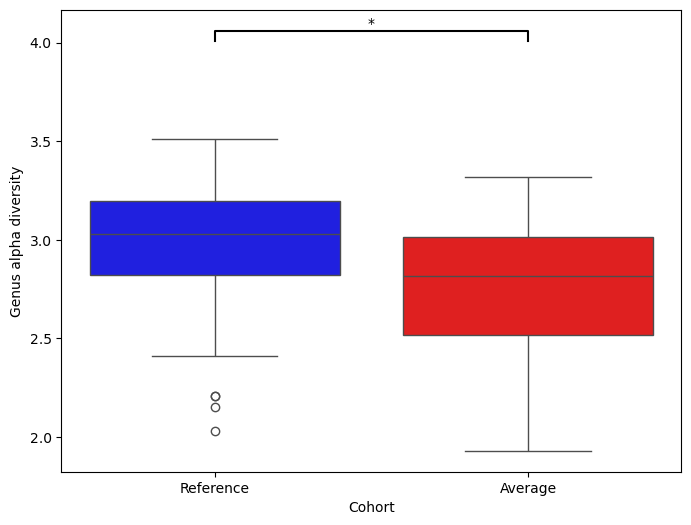

In [2]:
#Import datasets
rewell = pd.read_csv('resource/mxmarkers_rewell_con_enfermedad.csv')
reference = pd.read_csv('resource/mxmarkers_reference.csv')
df_reference = reference[['divalfa']].copy()
df_reference['source'] = 'Reference'  
df_rewell = rewell[['divalfa']].copy()
df_rewell['source'] = 'Average'

# Significance anotation
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Agrega una línea y anotación de significancia entre dos grupos."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)

# t-test
t_stat, p_value = ttest_ind(rewell['divalfa'], reference['divalfa'], equal_var=False)
 
# Concat dataframes
df_combined_rew_ref = pd.concat([df_reference[['divalfa', 'source']], df_rewell[['divalfa', 'source']]])

# Color definition
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Graph configuration
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df_combined_rew_ref, x='source', y='divalfa', palette=custom_palette)

# Significance line
y_position = df_combined_rew_ref['divalfa'].max() + 0.5
add_significance_line(ax, 0, 1, y_position, p_value)

# Title and labels
plt.ylabel('Genus alpha diversity')
plt.xlabel('Cohort')
plt.show()


## Fig 1B-D - Cazymes families and subfamilies diversity

C:\Users\milagros.trotta\AppData\Local\anaconda3\envs\cazymes\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.055392127143252236 whereas the largest positive one is 2.5142377628013173.
  warn(


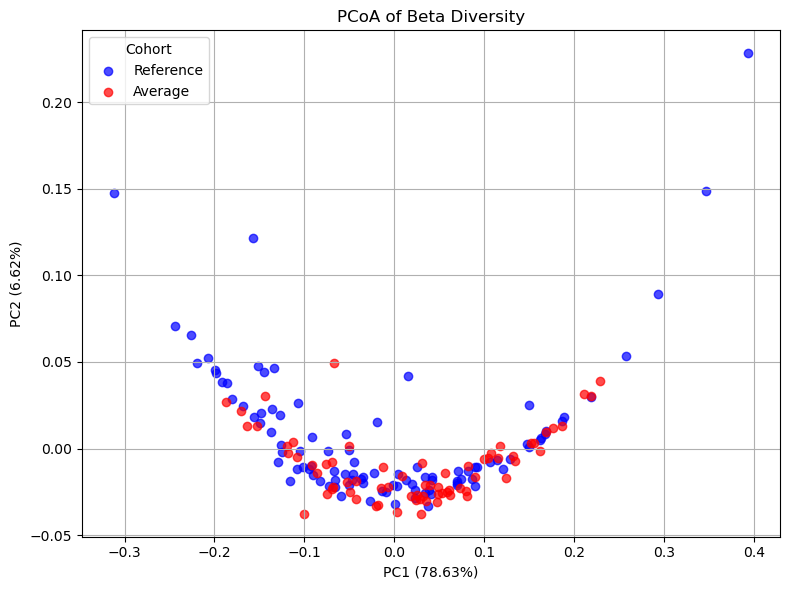

In [3]:
# Load data for both groups
file_paths = {
    'Reference': 'resource/familia_sum_tpm_dbref.csv',
    'Average': 'resource/familia_sum_tpm_rewell.csv'
}

# Read and reorganize data into a combined table
abundance_tables = []
for group, path in file_paths.items():
    df = pd.read_csv(path)
    abundance_table = df.pivot(index='muestra_id', columns='familia', values='SUM(valor)').fillna(0)
    abundance_table['Group'] = group  # Add group column
    abundance_tables.append(abundance_table)

# Combine both groups into a single table
combined_abundance_table = pd.concat(abundance_tables)

# Separate abundance data and group labels
abundance_data = combined_abundance_table.drop(columns=['Group'])
group_labels = combined_abundance_table['Group']

# **Beta Diversity**
# Calculate beta diversity using Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix = beta_diversity(metric, abundance_data.values, ids=abundance_data.index)

# **PCoA**
# Perform PCoA
from skbio.stats.ordination import pcoa
pcoa_results = pcoa(beta_matrix)

# Extract principal coordinates and add group labels
pcoa_df = pcoa_results.samples
pcoa_df['Group'] = group_labels.values

# Function to plot PCoA
def plot_pcoa(pcoa_df, pcoa_results, title):
    plt.figure(figsize=(8, 6))
    color_map = {'Reference': 'blue', 'Average': 'red'}

    for group, color in color_map.items():
        subset = pcoa_df[pcoa_df['Group'] == group]
        plt.scatter(subset['PC1'], subset['PC2'], alpha=0.7, color=color, label=group)

    plt.title(title)
    plt.xlabel("PC1 (%.2f%%)" % (pcoa_results.proportion_explained['PC1'] * 100))
    plt.ylabel("PC2 (%.2f%%)" % (pcoa_results.proportion_explained['PC2'] * 100))
    plt.grid(True)
    plt.legend(title='Cohort')
    plt.tight_layout()
    plt.show()

# Plot results
plot_pcoa(pcoa_df, pcoa_results, "PCoA of Beta Diversity")


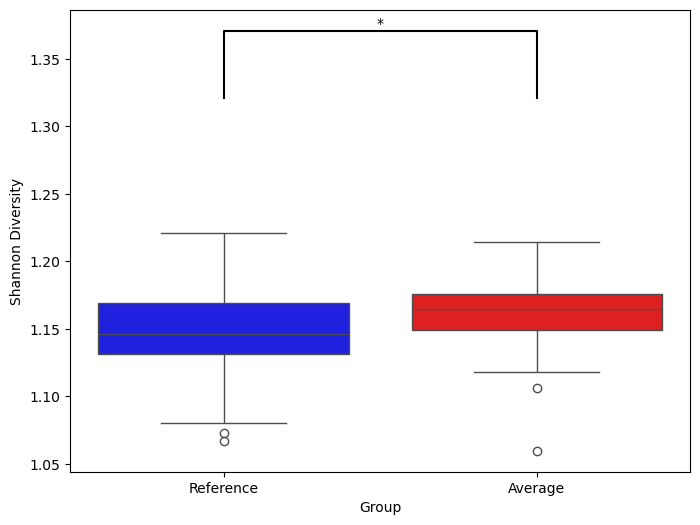

In [10]:
# Load the data for both groups
file_path_ref = 'resource/familia_sum_tpm_dbref.csv'  # Change the path as needed
ref = pd.read_csv(file_path_ref)
file_path_rew = 'resource/familia_sum_tpm_rewell.csv'
rew = pd.read_csv(file_path_rew)

# Reorganize the datasets
abundance_table_ref = ref.pivot(index='muestra_id', columns='familia', values='SUM(valor)').fillna(0)
abundance_table_rew = rew.pivot(index='muestra_id', columns='familia', values='SUM(valor)').fillna(0)

# Combine both groups into a single abundance table
combined_abundance_table = pd.concat([abundance_table_ref, abundance_table_rew])

# **Alpha Diversity**
# Calculate alpha diversity metrics
metrics = ['shannon']
alpha_results_ref = {metric: alpha_diversity(metric, abundance_table_ref.values, abundance_table_ref.index)
                     for metric in metrics}
alpha_results_rew = {metric: alpha_diversity(metric, abundance_table_rew.values, abundance_table_rew.index)
                     for metric in metrics}

# Convert results to DataFrame
alpha_df_rew = pd.DataFrame(alpha_results_rew, index=abundance_table_rew.index)

# Convert results to DataFrame
alpha_df_ref = pd.DataFrame(alpha_results_ref, index=abundance_table_ref.index)

# Add a column indicating the group ('ref' or 'rew')
alpha_df_ref['Group'] = 'Reference'
alpha_df_rew['Group'] = 'Average'

# Concatenate the DataFrames of both groups
alpha_df_combined = pd.concat([alpha_df_ref, alpha_df_rew])

# Transform to long format for boxplot using melt
alpha_df_long = alpha_df_combined.reset_index().melt(id_vars=['Group', 'muestra_id'], var_name='Metric', value_name='Alpha Diversity')

# Filter the DataFrame for each metric separately
alpha_df_shannon = alpha_df_long[alpha_df_long['Metric'] == 'shannon']

# Define specific colors for each group
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Perform t-test and add significance to the plots
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Adds a line and significance annotation between two groups."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)

# Plot for Shannon
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group', y='Alpha Diversity', data=alpha_df_shannon, palette=custom_palette, hue='Group')
plt.xlabel("Group")
plt.ylabel("Shannon Diversity")

# T-test for Shannon
shannon_ref = alpha_df_shannon[alpha_df_shannon['Group'] == 'Reference']['Alpha Diversity']
shannon_rew = alpha_df_shannon[alpha_df_shannon['Group'] == 'Average']['Alpha Diversity']
t_stat, p_val = ttest_ind(shannon_ref, shannon_rew)

# Add significance line
ax = plt.gca()
add_significance_line(ax, 0, 1, max(alpha_df_shannon['Alpha Diversity']) + 0.1, p_val)
plt.show()



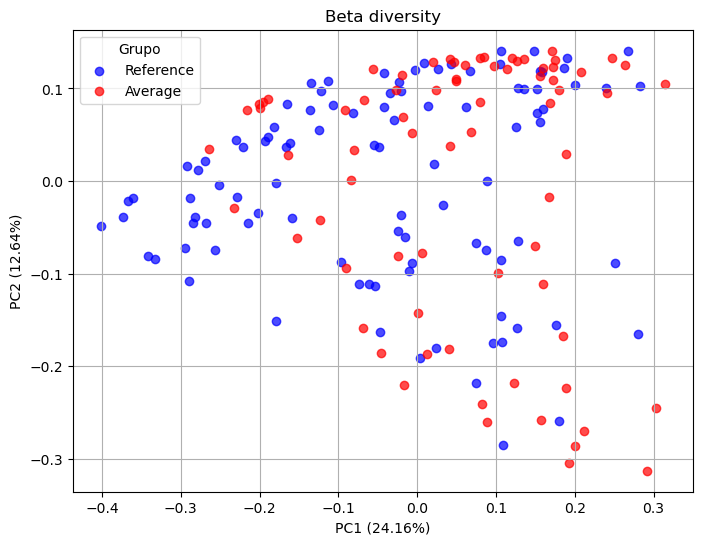

In [11]:
# Cargar los datos de ambos grupos
subfam_ref = pd.read_csv('resource/subfam_substrate_ref.csv') 
subfam_rew = pd.read_csv('resource/subfam_substrate_rewell.csv')


# Reorganizar los datasets
abundance_subfam_ref = subfam_ref.pivot(index='muestra_id', columns='subfam', values='valor').fillna(0)
abundance_subfam_rew = subfam_rew.pivot(index='muestra_id', columns='subfam', values='valor').fillna(0)

# Combinar ambos grupos en una sola tabla de abundancia
subfam_abundance_table = pd.concat([abundance_subfam_ref, abundance_subfam_rew]).fillna(0)

# **Beta Diversity**
# Calcular diversidad beta usando Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix_subfam = beta_diversity(metric, subfam_abundance_table.values, ids=subfam_abundance_table.index)

# Convertir a matriz cuadrada para visualizar
beta_square_subfam = squareform(beta_matrix_subfam.to_data_frame().values)

# **PCoA**
# Ejecutar PCoA
from skbio.stats.ordination import pcoa
pcoa_subfam_results = pcoa(beta_matrix_subfam)

# Extraer coordenadas principales
pcoa_subfam = pcoa_subfam_results.samples
pcoa_subfam['Group'] = ['Reference'] * len(abundance_subfam_ref) + ['Average'] * len(abundance_subfam_rew)  # Asignar grupo

# **Visualización**
plt.figure(figsize=(8, 6))

# Mapeo de colores para los grupos
color_map = {'Reference': 'blue', 'Average': 'red'}

# Graficar cada grupo con etiquetas
for group, color in color_map.items():
    subset = pcoa_subfam[pcoa_subfam['Group'] == group]
    plt.scatter(
        subset['PC1'], subset['PC2'], 
        alpha=0.7, c=color, label=group
    )

# Títulos y etiquetas de los ejes
plt.title("Beta diversity")
plt.xlabel("PC1 (%.2f%%)" % (pcoa_subfam_results.proportion_explained['PC1'] * 100))
plt.ylabel("PC2 (%.2f%%)" % (pcoa_subfam_results.proportion_explained['PC2'] * 100))
plt.grid(True)

# Agregar leyenda
plt.legend(title='Grupo')

# Mostrar gráfico
plt.show()

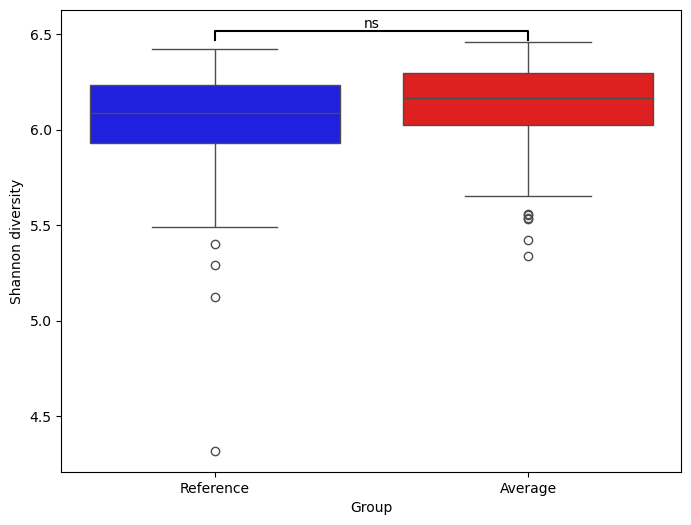

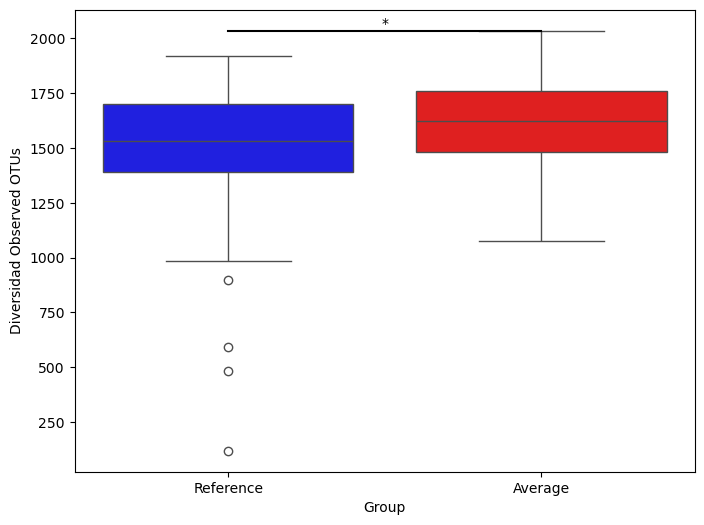

In [13]:
# Function to add the line and significance annotation
def add_significance_line(ax, group1, group2, y_position, p_value):
    """
    Adds a line and significance annotation between two groups.
    Only draws if p_value <= 0.05.
    """
    # Determine significance level
    significance = "ns" if p_value > 0.05 else (
        "*" if p_value <= 0.05 else (
        "**" if p_value <= 0.01 else (
        "***" if p_value <= 0.001 else "****")))

    # Draw the line and annotation only if significant
    if significance:
        x1, x2 = group1, group2
        y, h, col = y_position, 0.05, 'k'
        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)  # Line
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)  # Text


# **Alpha Diversity**
# Calculate alpha diversity metrics
metrics = ['shannon', 'observed_otus']
alpha_subfam_ref = {metric: alpha_diversity(metric, abundance_subfam_ref.values, abundance_subfam_ref.index)
                 for metric in metrics}
alpha_subfam_rew = {metric: alpha_diversity(metric, abundance_subfam_rew.values, abundance_subfam_rew.index)
                 for metric in metrics}

# Convert results to a DataFrame
alpha_subfam_ref = pd.DataFrame(alpha_subfam_ref, index=abundance_subfam_ref.index)
alpha_subfam_rew = pd.DataFrame(alpha_subfam_rew, index=abundance_subfam_rew.index)

# Add a column indicating the group ('ref' or 'rew')
alpha_subfam_ref['Group'] = 'Reference'
alpha_subfam_rew['Group'] = 'Average'

# Concatenate DataFrames from both groups
alpha_subfam_combined = pd.concat([alpha_subfam_ref, alpha_subfam_rew])

# Transform to long format for the boxplot using melt
alpha_subfam_long = alpha_subfam_combined.reset_index().melt(id_vars=['Group'], var_name='Metric', value_name='Alpha Diversity')

# Ensure the column is numeric and handle missing values
alpha_subfam_long['Alpha Diversity'] = pd.to_numeric(alpha_subfam_long['Alpha Diversity'], errors='coerce')
alpha_subfam_long = alpha_subfam_long.dropna(subset=['Alpha Diversity'])

# Filter the DataFrame for each metric separately
alpha_subfam_shannon = alpha_subfam_long[alpha_subfam_long['Metric'] == 'shannon']
alpha_subfam_otus = alpha_subfam_long[alpha_subfam_long['Metric'] == 'observed_otus']

# Create boxplots with significance lines
metrics_data = [
    (alpha_subfam_shannon, "Alpha diversity (Shannon)", "Shannon diversity"),
    (alpha_subfam_otus, "Alpha Diversity (Observed OTUs)", "Observed OTUs Diversity")
]

for data, title, ylabel in metrics_data:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Group', y='Alpha Diversity', data=data, palette=custom_palette, hue='Group')
    # plt.title(title)
    plt.xlabel("Group")
    plt.ylabel(ylabel)
    
    # Perform the t-test
    group_ref = data[data['Group'] == 'Reference']['Alpha Diversity']
    group_rew = data[data['Group'] == 'Average']['Alpha Diversity']
    t_stat, p_val = ttest_ind(group_ref, group_rew, nan_policy='omit')  # Ignore missing values
    
    # Add significance line
    ax = plt.gca()
    add_significance_line(ax, 0, 1, max(data['Alpha Diversity']) + 0.01, p_val)
    plt.show()


## Fig 2

C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_29344\2109055406.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Etiquetas personalizadas
C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_29344\2109055406.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Etiquetas personalizadas
C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_29344\2109055406.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Etiquetas personalizadas
C:\Users\milagros.trotta\AppData\Local\Temp\ipykernel_29344\2109055406.py:73: UserWarning: set_ticklabels() should onl

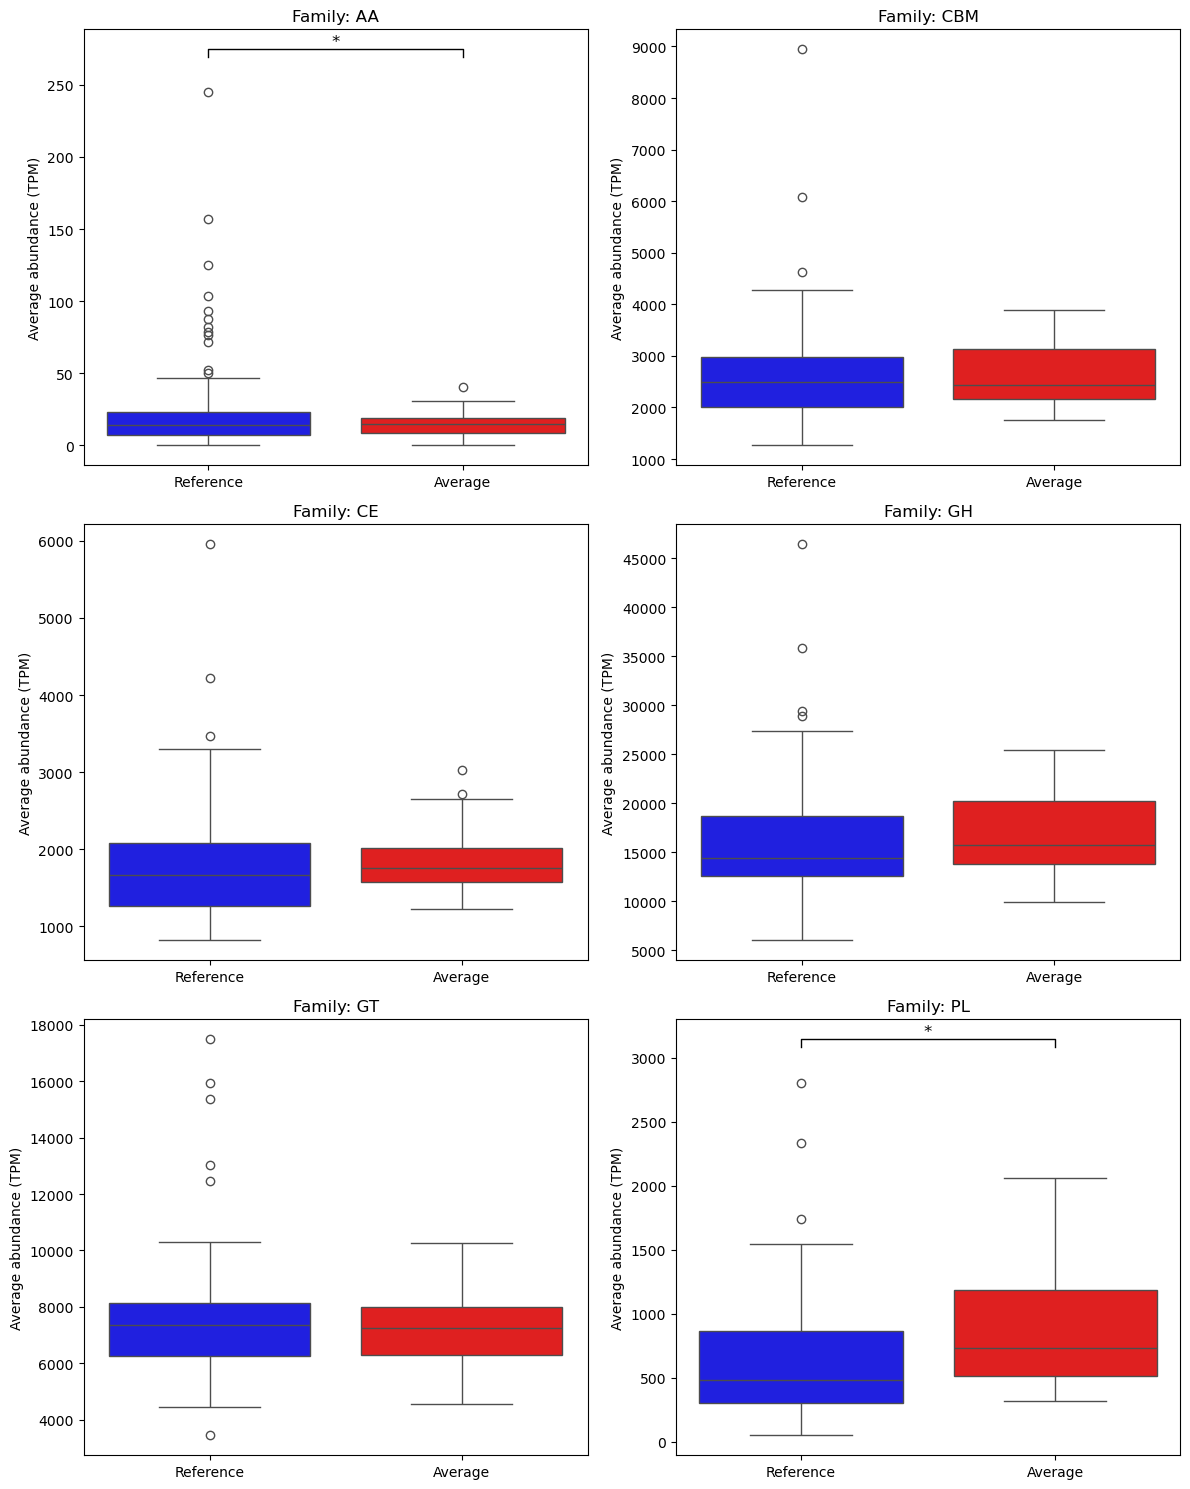

In [27]:
df_dbref_fam = pd.read_csv('resource/familia_sum_tpm_dbref.csv')
df_rewell_fam = pd.read_csv('resource/cazy_rewell_con_enfermedad.csv')

# Rename the column
df_dbref_fam.rename(columns={"SUM(valor)": "value"}, inplace=True)
df_rewell_fam.rename(columns={"valor": "value"}, inplace=True)

family_gruop_rewell = df_rewell_fam.groupby(['familia', 'muestra_id'])['value'].sum().reset_index()

df_dbref_fam['grupo'] = 'Reference'
family_gruop_rewell['grupo'] = 'Average'

# Define specific colors for each group
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Combine only df_dbref and df_rewell
data = pd.concat([df_dbref_fam, family_gruop_rewell])

# Unique families
familias = data['familia'].unique()

# Configure number of rows and columns
num_familias = len(familias)
ncols = 2  # Two columns
nrows = math.ceil(num_familias / ncols)  # Calculate the required number of rows

# Create subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 5 * nrows), sharex=False)
axes = axes.flatten()  # Flatten for easy iteration

# Function to add significance bars
def add_significance_bar(ax, x1, x2, y, significance):
    """
    Adds a significance bar between two points on the x-axis.
    """
    bar_height = 0.02 * y  # Bar height as a percentage of the maximum value
    ax.plot([x1, x1, x2, x2], [y, y + bar_height, y + bar_height, y], color="black", lw=1)
    ax.text(
        (x1 + x2) / 2, y + bar_height, significance, ha='center', va='bottom', color='black', fontsize=12
    )

for ax, familia in zip(axes, familias):
    # Filter data for the current family
    familia_data = data[data['familia'] == familia]
    
    # Split the groups
    grupo_dbref = familia_data[familia_data['grupo'] == 'Reference']['value']
    grupo_rewell = familia_data[familia_data['grupo'] == 'Average']['value']
    
    # Perform the t-test
    t_stat, p_value = ttest_ind(grupo_dbref, grupo_rewell, equal_var=False)

    # Create the boxplot for this family
    sns.boxplot(
        data=familia_data,
        x='grupo',
        y='value',
        ax=ax,
        palette=custom_palette,
        hue='grupo'
    )
    
    # Add the t-test result to the plot if significant
    if p_value <= 0.05:
        significance = '*' if p_value > 0.01 else '**' if p_value > 0.001 else '***'
        max_y = familia_data['value'].max()
        add_significance_bar(ax, 0, 1, max_y + 0.1 * max_y, significance)  # Call the function
    
    # Customize the plot
    ax.set_title(f'Family: {familia}')
    ax.set_xlabel('')  # Remove default X-axis label
    ax.set_ylabel('Average abundance (TPM)')
    ax.set_xticklabels(['Reference', 'Average'], fontsize=10)  # Custom labels

# Disable extra plots if there are unused subplots
for ax in axes[num_familias:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


## Fig 3

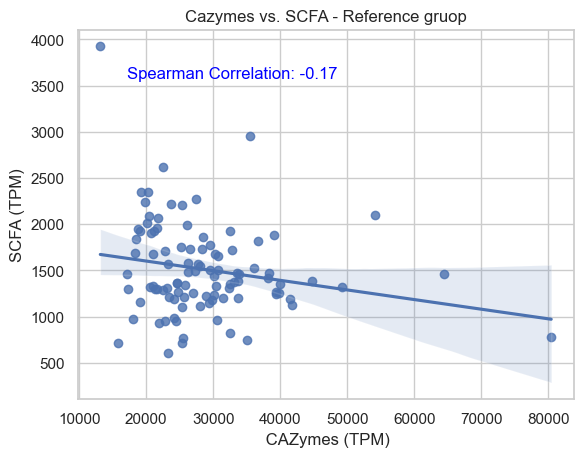

In [28]:
dbref_scfa = pd.read_csv('resource/cazy-scfa-ref.csv')
rew_scfa = pd.read_csv('resource/cazy-scfa-rew.csv')

# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(dbref_scfa['SUM_cazy'])
stat_y, p_value_y = stats.shapiro(dbref_scfa['suma_scfa'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(dbref_scfa['SUM_cazy'], dbref_scfa['suma_scfa'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(dbref_scfa['SUM_cazy'], dbref_scfa['suma_scfa'])
    corr_type = "Spearman"

# Set the style of the plots
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM_cazy', y='suma_scfa', data=dbref_scfa)

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='blue', verticalalignment='top')

# Titles and labels
plt.title("Cazymes vs. SCFA - Reference group")
plt.xlabel("CAZymes (TPM)")
plt.ylabel("SCFA (TPM)")

# Show the plot
plt.show()


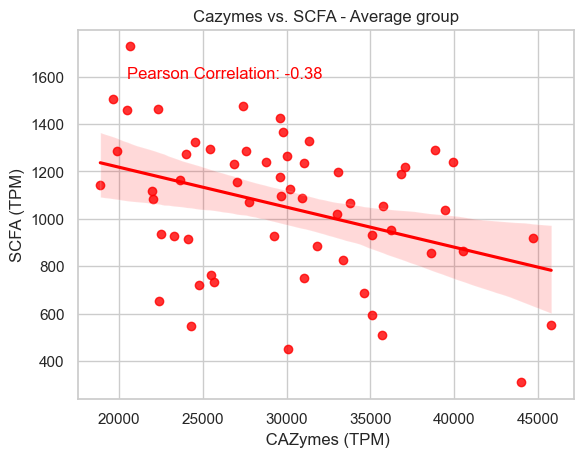

In [29]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(rew_scfa['SUM_cazy'])
stat_y, p_value_y = stats.shapiro(rew_scfa['suma_scfa'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(rew_scfa['SUM_cazy'], rew_scfa['suma_scfa'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(rew_scfa['SUM_cazy'], rew_scfa['suma_scfa'])
    corr_type = "Spearman"

# Set the style of the plots
sns.set(style="whitegrid")

# Create the plot with red color
sns.regplot(x='SUM_cazy', y='suma_scfa', data=rew_scfa, color='red')

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='red', verticalalignment='top')

# Titles and labels
plt.title("Cazymes vs. SCFA - Average group")
plt.xlabel("CAZymes (TPM)")
plt.ylabel("SCFA (TPM)")

# Show the plot
plt.show()


## Fig 4

In [30]:
pl_scfa_ref= pd.read_csv('resource/PL-AGCC-REF.csv')
pl_scfa_rew= pd.read_csv('resource/PL-AGCC-REW.csv')
gh_scfa_ref= pd.read_csv('resource/GH-AGCC-REF.csv')
gh_scfa_rew= pd.read_csv('resource/GH-AGCC-REW.csv')

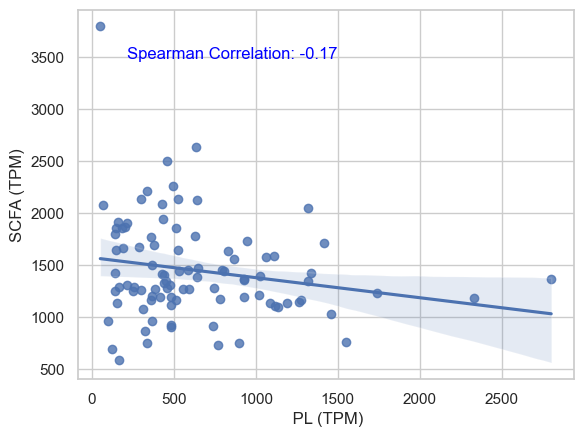

In [32]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(pl_scfa_ref['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(pl_scfa_ref['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(pl_scfa_ref['SUM(SUM_Cazy)'], pl_scfa_ref['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(pl_scfa_ref['SUM(SUM_Cazy)'], pl_scfa_ref['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=pl_scfa_ref)

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='blue', verticalalignment='top')

# Titles and labels
plt.xlabel(" PL (TPM)")
plt.ylabel("SCFA (TPM)")

# Show the plot
plt.show()


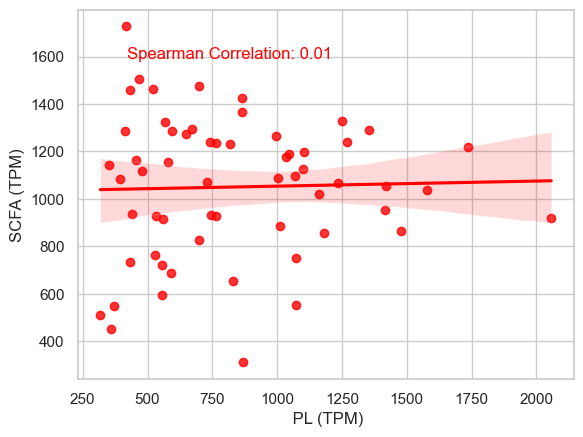

In [33]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(pl_scfa_rew['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(pl_scfa_rew['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(pl_scfa_rew['SUM(SUM_Cazy)'], pl_scfa_rew['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(pl_scfa_rew['SUM(SUM_Cazy)'], pl_scfa_rew['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=pl_scfa_rew, color='red')

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='red', verticalalignment='top')

# Titles and labels
#plt.title("PL - SCFA - wellness group")
plt.xlabel(" PL (TPM)")
plt.ylabel("SCFA (TPM)")

# Show the plot
plt.show()


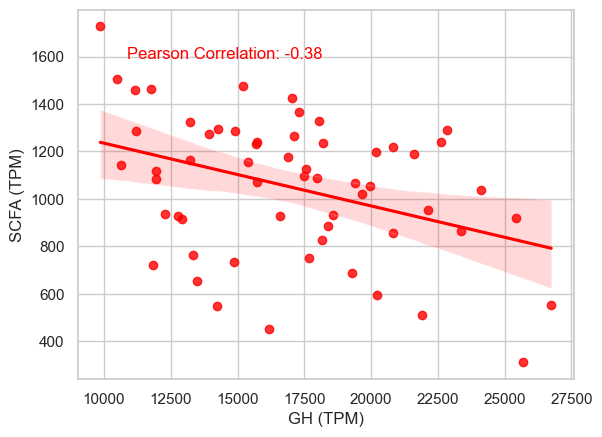

In [34]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(gh_scfa_rew['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(gh_scfa_rew['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(gh_scfa_rew['SUM(SUM_Cazy)'], gh_scfa_rew['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(gh_scfa_rew['SUM(SUM_Cazy)'], gh_scfa_rew['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=gh_scfa_rew, color='red')

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='red', verticalalignment='top')

# Titles and labels
#plt.title("GH - SCFA - wellness group")
plt.xlabel("GH (TPM)")
plt.ylabel("SCFA (TPM)")

# Show the plot
plt.show()


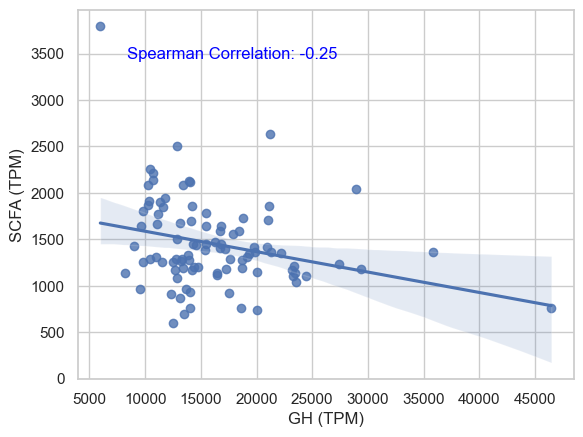

In [35]:
# Normality test (Shapiro-Wilk) for both variables
stat_x, p_value_x = stats.shapiro(gh_scfa_ref['SUM(SUM_Cazy)'])
stat_y, p_value_y = stats.shapiro(gh_scfa_ref['MAX(scfa_full)'])

# Check if both variables are normal (p < 0.05 suggests non-normality)
if p_value_x > 0.05 and p_value_y > 0.05:
    # If both are normal, use Pearson
    correlation, _ = stats.pearsonr(gh_scfa_ref['SUM(SUM_Cazy)'], gh_scfa_ref['MAX(scfa_full)'])
    corr_type = "Pearson"
else:
    # If at least one is not normal, use Spearman
    correlation, _ = stats.spearmanr(gh_scfa_ref['SUM(SUM_Cazy)'], gh_scfa_ref['MAX(scfa_full)'])
    corr_type = "Spearman"

# Set the plot style
sns.set(style="whitegrid")

# Create the plot
sns.regplot(x='SUM(SUM_Cazy)', y='MAX(scfa_full)', data=gh_scfa_ref)

# Add the correlation value to the plot
plt.text(0.1, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=plt.gca().transAxes,
         fontsize=12, color='blue', verticalalignment='top')

# Titles and labels
#plt.title("GH - SCFA - reference group")
plt.xlabel("GH (TPM)")
plt.ylabel("SCFA (TPM)")

# Show the plot
plt.show()


## Fig 5

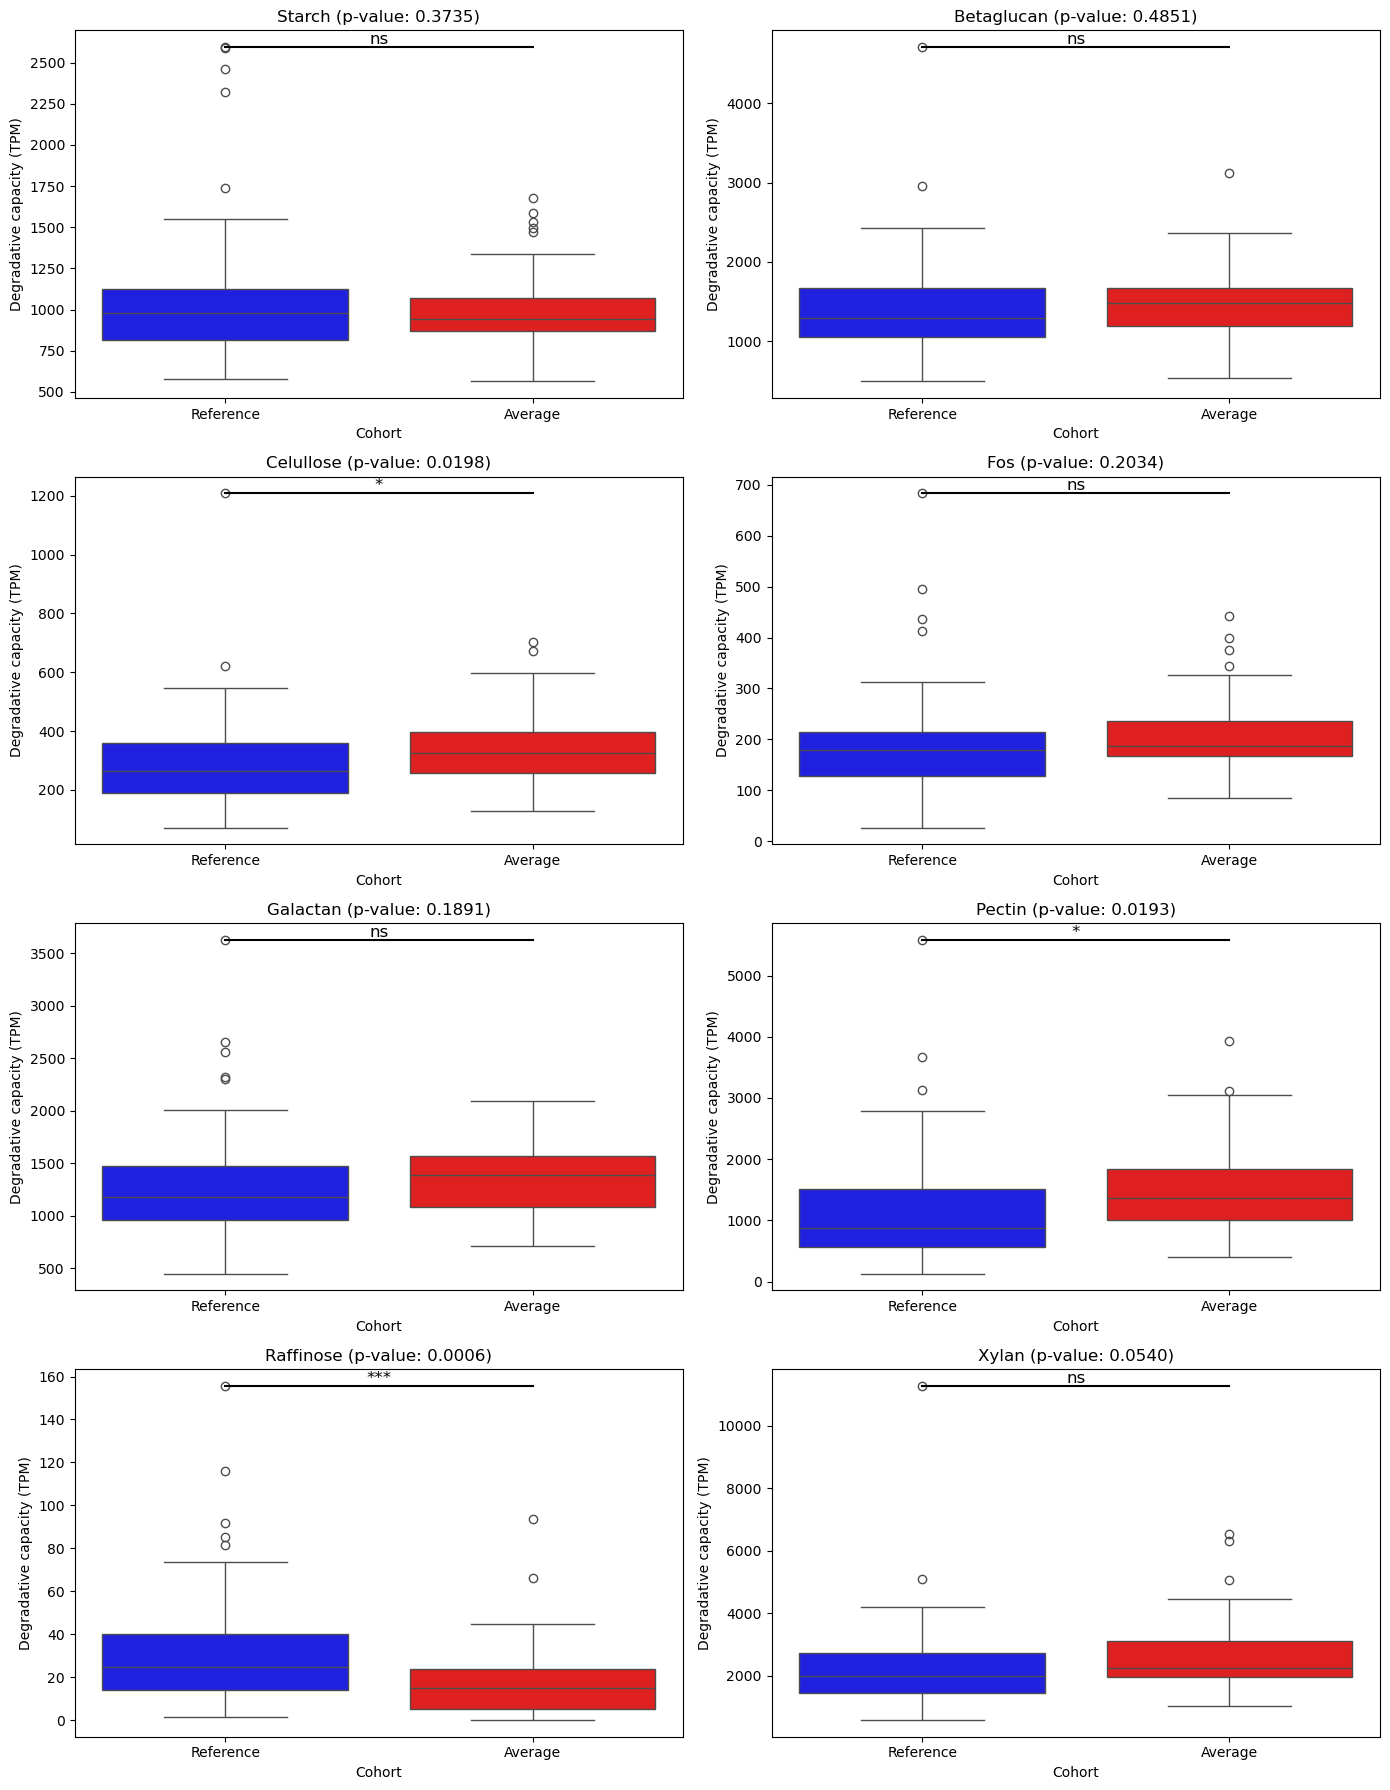

In [4]:
# Dataframe list
dataframes = [
    ('starch_ref', pd.read_csv('resource/cap-deg-almidon-ref.csv')),
    ('starch_rew', pd.read_csv('resource/cap-deg-almidon-rew.csv')),
    ('betaglucan_ref', pd.read_csv('resource/cap-deg-betaglucano-ref.csv')),
    ('betaglucan_rew', pd.read_csv('resource/cap-deg-betaglucano-rew.csv')),
    ('celullose_ref', pd.read_csv('resource/cap-deg-celulosa-ref.csv')),
    ('celullose_rew', pd.read_csv('resource/cap-deg-celulosa-rew.csv')),
    ('fos_ref', pd.read_csv('resource/cap-deg-FOS-ref.csv')),
    ('fos_rew', pd.read_csv('resource/cap-deg-fructan-rew.csv')),
    ('galactan_ref', pd.read_csv('resource/cap-deg-galac-ref.csv')),
    ('galactan_rew', pd.read_csv('resource/cap-deg-galac-rew.csv')),
    ('pectin_ref', pd.read_csv('resource/cap-deg-pectina-ref.csv')),
    ('pectin_rew', pd.read_csv('resource/cap-deg-pectina-rew.csv')),
    ('raffinose_ref', pd.read_csv('resource/cap-deg-rafinosa-ref.csv')),
    ('raffinose_rew', pd.read_csv('resource/cap-deg-rafinosa-rew.csv')),
    ('xylan_ref', pd.read_csv('resource/cap-deg-xilano-ref.csv')),
    ('xylan_rew', pd.read_csv('resource/cap-deg-xilano-rew.csv'))
]

# Definir los colores específicos para cada grupo
custom_palette = {'Reference': 'blue', 'Average': 'red'}

# Crear un diccionario para almacenar los dataframes agrupados
dataframes_grouped = {}

# Agrupar cada dataframe por 'muestra_id' y sumar la columna 'SUM_Cazy'
for name, df in dataframes:
    if df is not None and not df.empty:
        df_grouped = df.groupby('muestra_id').agg({
            'SUM_Cazy': 'sum',
            'substrate': 'first'
        }).reset_index()
        dataframes_grouped[name] = df_grouped

# Función para convertir el p-valor en un nivel de significancia
def get_significance(p_value):
    if p_value < 0.0001:
        return '****'
    elif p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# Visualizar boxplots y realizar t-test
substrates = ['starch', 'betaglucan', 'celullose', 'fos', 'galactan', 'pectin', 'raffinose', 'xylan']
fig, axes = plt.subplots(nrows=(len(substrates) + 1) // 2, ncols=2, figsize=(14, 18))

for idx, substrate in enumerate(substrates):
    row, col = divmod(idx, 2)
    ax = axes[row, col]
    
    df_ref = dataframes_grouped.get(f'{substrate}_ref')  # Dataframe de referencia
    df_rew = dataframes_grouped.get(f'{substrate}_rew')  # Dataframe de bienestar
    
    if df_ref is not None and df_rew is not None:
        df_ref['grupo'] = 'Reference'
        df_rew['grupo'] = 'Average'
        
        df_combined = pd.concat([df_ref[['muestra_id', 'SUM_Cazy', 'grupo']], 
                                 df_rew[['muestra_id', 'SUM_Cazy', 'grupo']]])
        
        sns.boxplot(x='grupo', y='SUM_Cazy', data=df_combined, palette=custom_palette, ax=ax, hue='grupo')
        
        # Realizar el t-test
        t_stat, p_value = stats.ttest_ind(df_ref['SUM_Cazy'], df_rew['SUM_Cazy'])
        significance = get_significance(p_value)
        
        # Añadir líneas y asteriscos al gráfico
        x1, x2 = 0, 1  # Posiciones de los grupos
        y, h, col = df_combined['SUM_Cazy'].max() + 0.1, 0.05, 'black'
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col, fontsize=12)
        
        ax.set_title(f'{substrate.capitalize()} (p-value: {p_value:.4f})', fontsize=12)
        ax.set_xlabel('Cohort', fontsize=10)
        ax.set_ylabel('Degradative capacity (TPM)', fontsize=10)
        ax.grid(False)
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()


## Fig 6

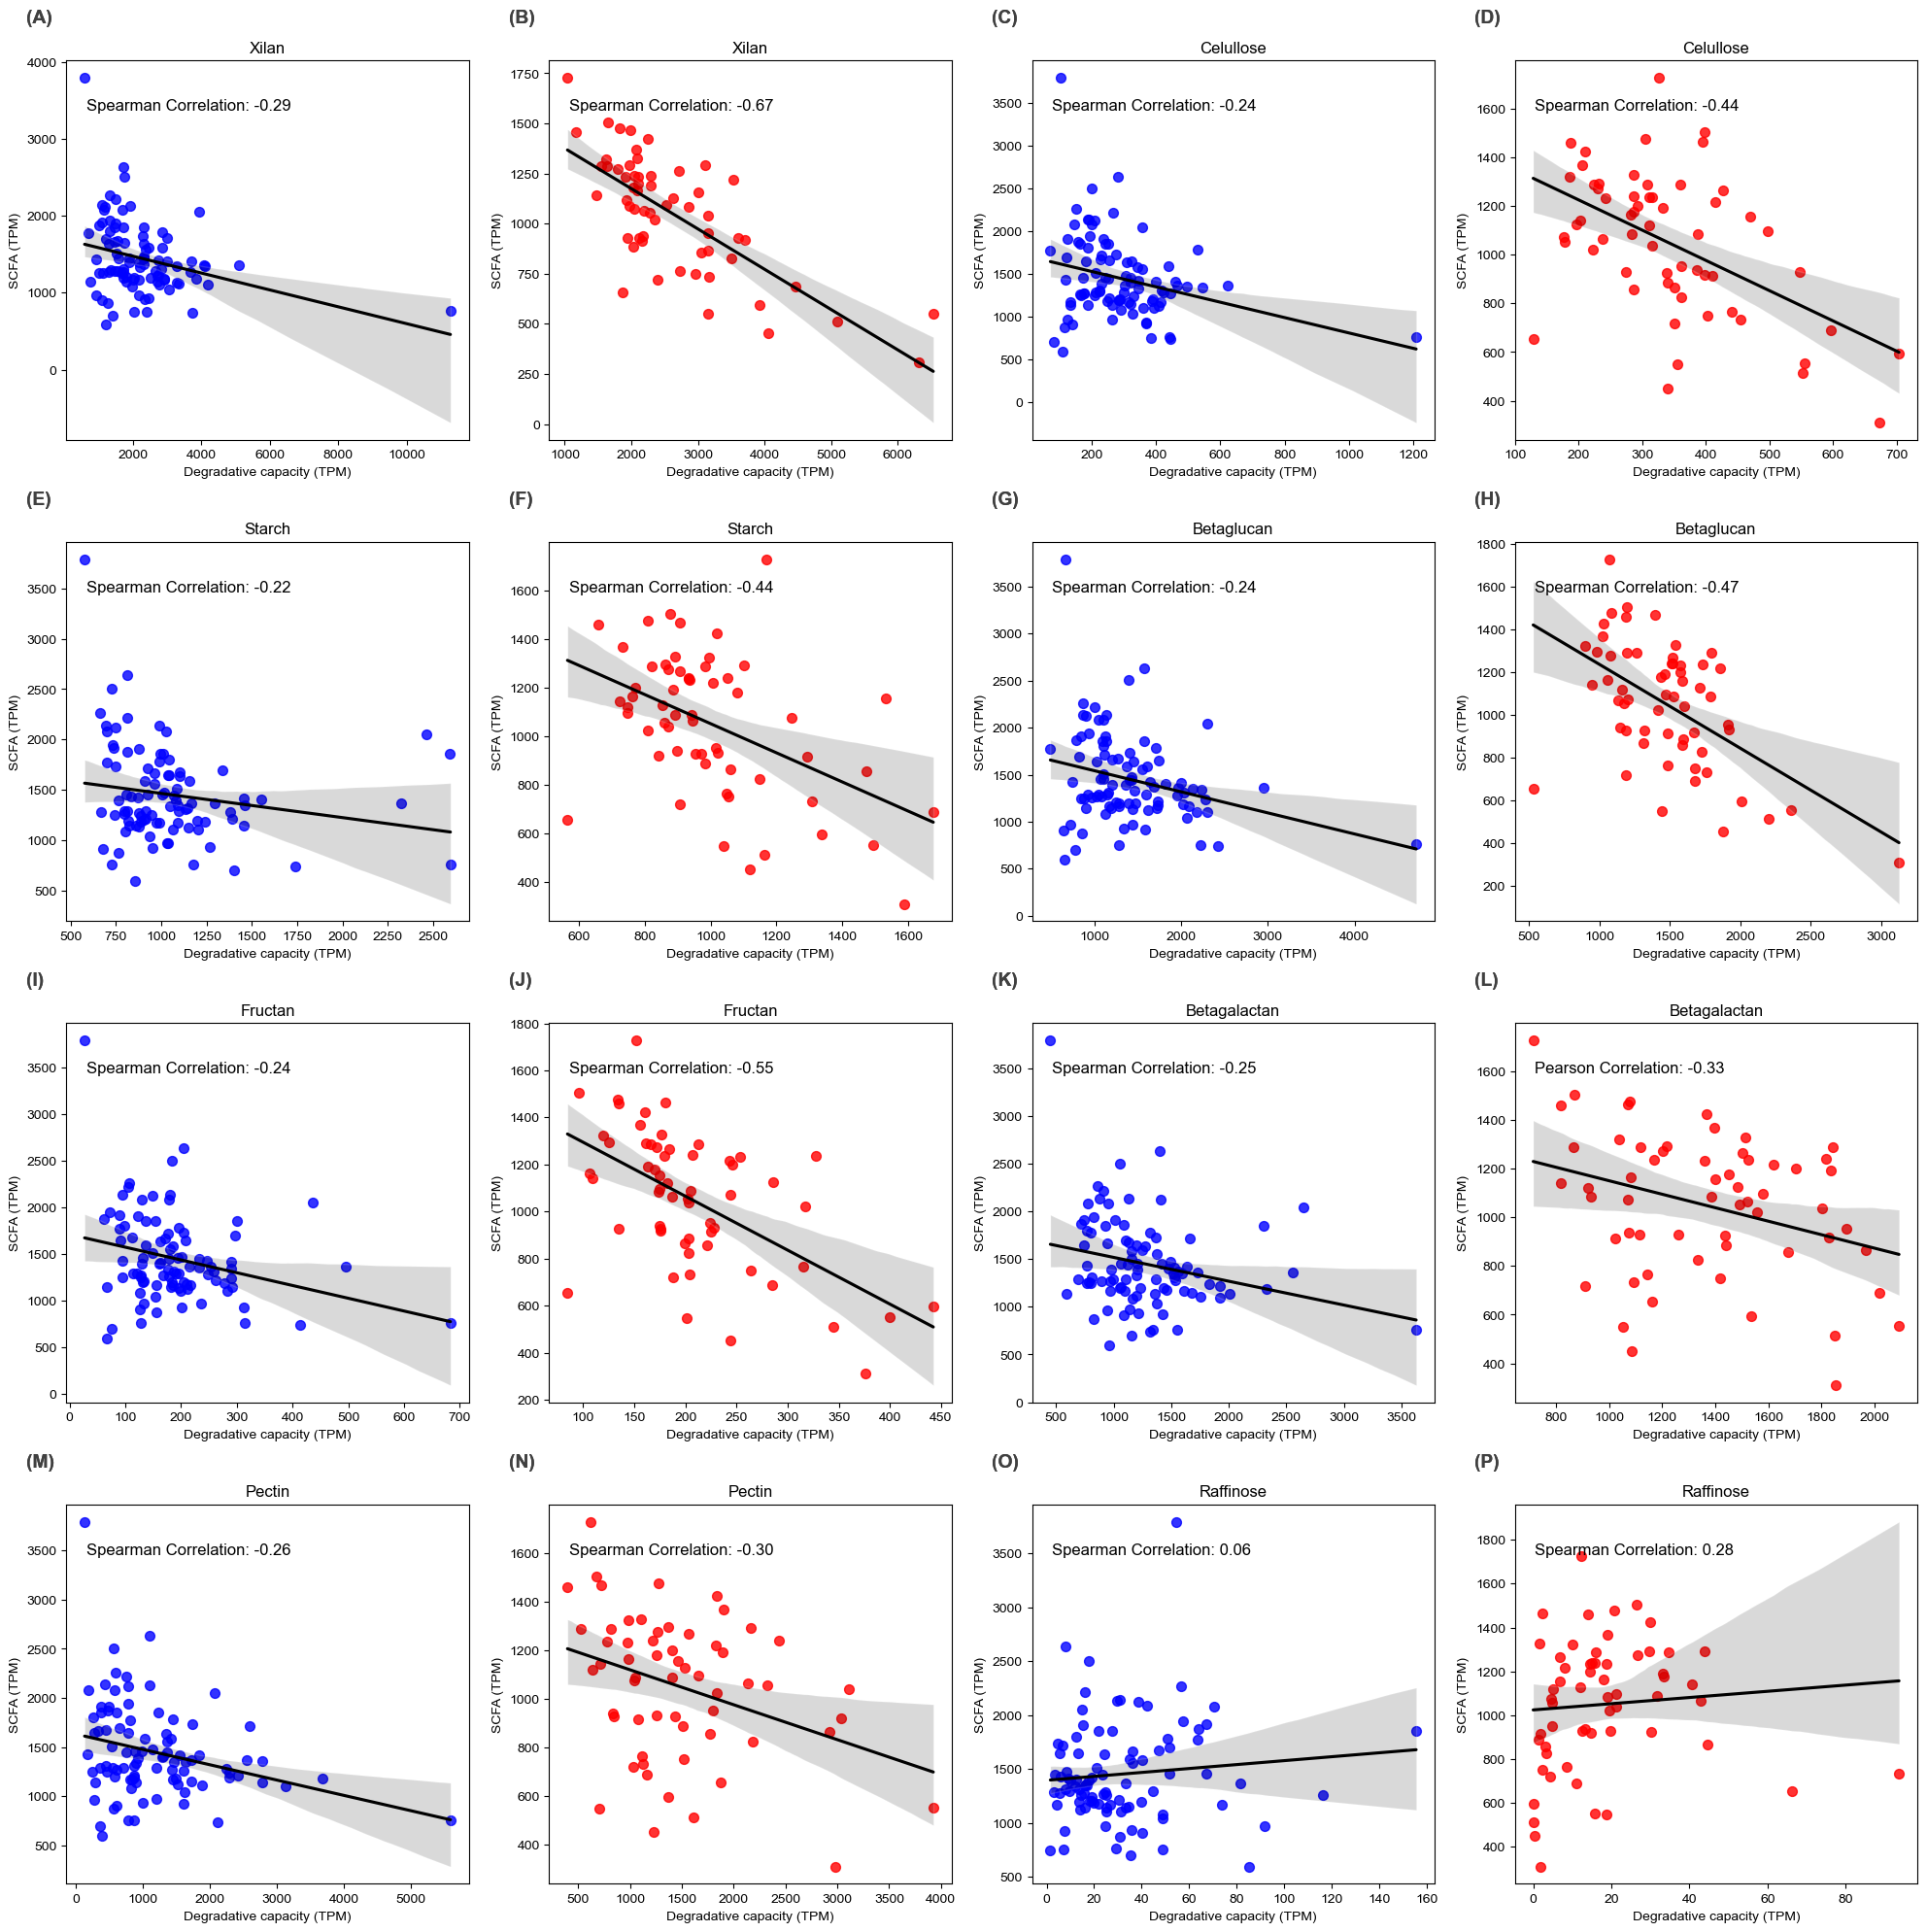

In [5]:
pectina_dbref = pd.read_csv('resource/pectina-agcc-ref.csv')
pectina_rewell = pd.read_csv('resource/pectina-agcc-rew.csv')
rafinosa_dbref = pd.read_csv('resource/rafinosa-agcc-ref.csv')
rafinosa_rewell = pd.read_csv('resource/rafinosa-agcc-rew.csv')
xilano_dbref = pd.read_csv('resource/xilano-agcc-ref.csv')
xilano_rewell = pd.read_csv('resource/xilano-agcc-rew.csv')
celulosa_dbref = pd.read_csv('resource/celulosa-agcc-ref.csv')
celulosa_rewell = pd.read_csv('resource/celulosa-agcc-rew.csv')
almidon_dbref = pd.read_csv('resource/almidon-agcc-ref.csv')
almidon_rewell = pd.read_csv('resource/almidon-agcc-rew.csv')
betaglu_dbref = pd.read_csv('resource/betaglucano-agcc-ref.csv')
betaglu_rewell = pd.read_csv('resource/betaglucano-agcc-rew.csv')
fructan_dbref = pd.read_csv('resource/FOS-agcc-ref.csv')
fructan_rewell = pd.read_csv('resource/FOS-agcc-rew.csv')
betagal_dbref = pd.read_csv('resource/GOS-agcc-ref.csv')
betagal_rewell = pd.read_csv('resource/GOS-agcc-rew.csv')

# Function to calculate correlation and display the plot
def plot_correlation(df, x_column, y_column, title, ax, color, label):
    """
    Generates a correlation plot with a regression line and custom colors.

    Args:
        df (pd.DataFrame): DataFrame with data.
        x_column (str): Name of the column for the X-axis.
        y_column (str): Name of the column for the Y-axis.
        title (str): Title of the plot.
        ax (matplotlib.Axes): Subplot to draw the plot on.
        color (str): Color for the points and regression line.
        label (str): Label to annotate the subplot.
    """
    # Normality test (Shapiro-Wilk) for both variables
    stat_x, p_value_x = stats.shapiro(df[x_column])
    stat_y, p_value_y = stats.shapiro(df[y_column])

    # Determine correlation type based on normality
    if p_value_x > 0.05 and p_value_y > 0.05:
        correlation, _ = stats.pearsonr(df[x_column], df[y_column])
        corr_type = "Pearson"
    else:
        correlation, _ = stats.spearmanr(df[x_column], df[y_column])
        corr_type = "Spearman"

    # Set up the plot style
    sns.set(style="whitegrid")

    # Create the plot on the provided subplot `ax`
    sns.regplot(x=x_column, y=y_column, data=df, ax=ax, color=color, scatter_kws={'s': 50}, line_kws={'color': 'black'})

    # Add correlation value to the plot
    ax.text(0.05, 0.9, f'{corr_type} Correlation: {correlation:.2f}', transform=ax.transAxes,
            fontsize=12, color='black', verticalalignment='top')

    # Add the letters in dark gray (#404040) at the top-left corner of each subplot
    ax_ref.text(-0.1, 1.1, f'({label_ref})', transform=ax_ref.transAxes, fontsize=14, color='#404040', fontweight='bold')
    ax_wellness.text(-0.1, 1.1, f'({label_wellness})', transform=ax_wellness.transAxes, fontsize=14, color='#404040', fontweight='bold')

    # Set titles and labels
    ax.set_title(title)
    ax.set_xlabel('Degradative capacity (TPM)')
    ax.set_ylabel('SCFA (TPM)')

# Create subplots: (4 rows, 4 columns)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Substrate information
sustratos = [
    ('xilan', xilano_dbref, xilano_rewell), 
    ('celullose', celulosa_dbref, celulosa_rewell), 
    ('starch', almidon_dbref, almidon_rewell), 
    ('betaglucan', betaglu_dbref, betaglu_rewell),
    ('fructan', fructan_dbref, fructan_rewell),
    ('betagalactan', betagal_dbref, betagal_rewell),
    ('pectin', pectina_dbref, pectina_rewell),
    ('raffinose', rafinosa_dbref, rafinosa_rewell)
]

# Alphabet labels for the plots
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

# Iterate over substrates and create the plots
for i, (sustrato, df_ref, df_wellness) in enumerate(sustratos):
    row = i // 2
    col = i % 2
    ax_ref = axes[row, col*2]  # Subplot for the reference group (even column)
    ax_wellness = axes[row, col*2 + 1]  # Subplot for the wellness group (odd column)

    # Add labels for the subplots
    label_ref = alphabet[i*2]  # Letter for the reference subplot
    label_wellness = alphabet[i*2 + 1]  # Letter for the wellness subplot

    # Plot for each group (reference and wellness)
    plot_correlation(df_ref, 'SUM(SUM_Cazy)', 'MAX(scfa_full)', f'{sustrato.capitalize()}', ax_ref, color='blue', label=label_ref)
    plot_correlation(df_wellness, 'SUM(SUM_Cazy)', 'MAX(scfa_full)', f'{sustrato.capitalize()}', ax_wellness, color='red', label=label_wellness)

# Adjust spacing between plots
plt.tight_layout()

# Show all plots
plt.show()


## Fig 7

grupo
IBD        2.602857
control    2.860000
Name: divalfa, dtype: float64
Estadístico t: -2.259
Valor p: 0.030


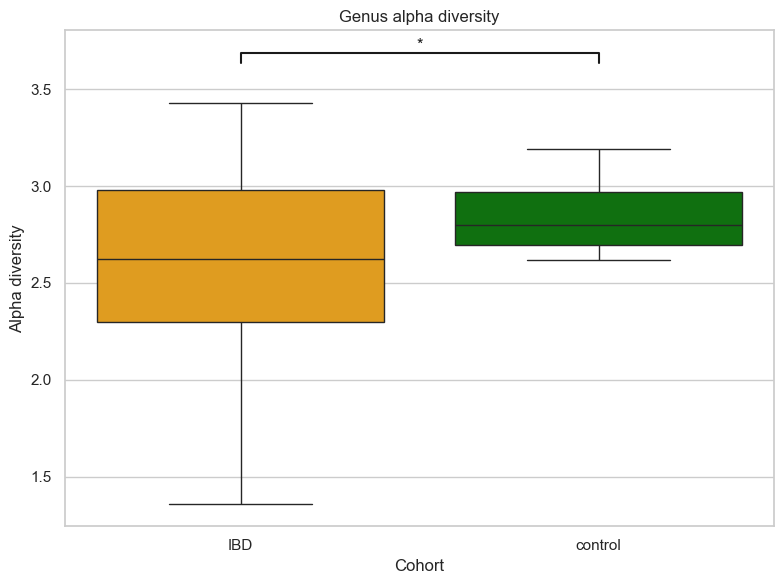

In [18]:
mxmarkers_ibd = pd.read_csv("resource/romagnoli_etiquetados.csv")


mxmarkers_neg = mxmarkers_ibd[mxmarkers_ibd['kit_id'].str.contains('neg')]
mxmarkers_neg

# Definir los colores específicos para cada grupo
custom_palette = {'control': 'green', 'IBD': 'orange'}

# Función para agregar la línea y la anotación de significancia
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Agrega una línea y anotación de significancia entre dos grupos."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col, fontsize=12)

# Crear el gráfico
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='grupo', y='divalfa', data=mxmarkers_neg, palette=custom_palette, hue='grupo')

# Etiquetas y título
plt.xlabel('Cohort')
plt.ylabel('Alpha diversity')
plt.title('Genus alpha diversity')

# Calcular la media para cada grupo (opcional, para referencia)
media_por_grupo_divalfa_neg = mxmarkers_neg.groupby('grupo')['divalfa'].mean()
print(media_por_grupo_divalfa_neg)

# Realizar t-test
casos_divalfa_neg = mxmarkers_neg[mxmarkers_neg['grupo'] == 'IBD']['divalfa']
controles_divalfa_neg = mxmarkers_neg[mxmarkers_neg['grupo'] == 'control']['divalfa']

t_stat, p_value = stats.ttest_ind(casos_divalfa_neg, controles_divalfa_neg, equal_var=False)  # Welch's t-test

print(f"Estadístico t: {t_stat:.3f}")
print(f"Valor p: {p_value:.3f}")

# Agregar la línea de significancia y el p-valor en el gráfico
y_max = mxmarkers_neg['divalfa'].max()  # Obtener el valor máximo de y
margin = 0.1 * (y_max - mxmarkers_neg['divalfa'].min())  # Margen basado en el rango
line_y_position = y_max + margin  # Posición de la línea

# Índices de los grupos en el boxplot (asumimos 0 para 'IBD' y 1 para 'control')
add_significance_line(ax, 0, 1, line_y_position, p_value)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [19]:
UC = pd.read_csv('resource/run240628NEXromagnoli.resumido.CAZY_values_processed.csv')
CD = pd.read_csv('resource/run240729NEXromagnoli.resumido.CAZY_values_processed.csv')
control = pd.read_csv('resource/run240412NIXromagnoliresumido..CAZY_values_processed 1.csv')
df_rom = pd.concat([UC, CD])
# Filtrar datos donde 'tubo' es 'neg'
df_neg = df_rom[df_rom['tubo'] == 'neg']
control_neg = control[control['tubo'] == 'neg']

# Filtrar datos donde 'tubo' es 'pos'
df_pos = df_rom[df_rom['tubo'] == 'pos']
control_pos = control[control['tubo'] == 'pos']

#Agrupar subfamilias
df_pos_subfam = df_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
control_pos_subfam = control_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
df_neg_subfam = df_neg.groupby(['subfam', 'kit_id'])['value'].sum().reset_index()
control_neg_subfam = control_neg.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()

# Renombrar la columna 'kit_id' a 'muestra_id' en los dataframes
df_neg_subfam = df_neg_subfam.rename(columns={'kit_id': 'muestra_id'})
df_pos_subfam = df_pos_subfam.rename(columns={'kit_id': 'muestra_id'})

# Reorganizar el dataset
abundance_subfam_neg_ibd = df_neg_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_pos_ibd = df_pos_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_neg_control = control_neg_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_pos_control = control_pos_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)



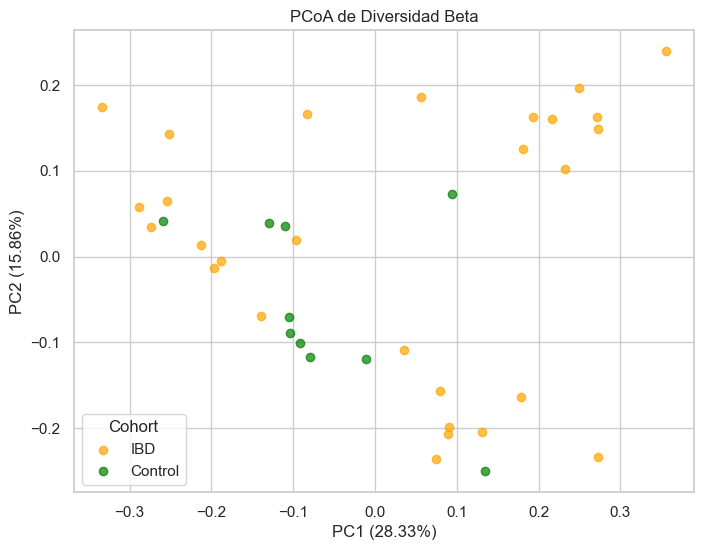

In [21]:
# **Beta Diversity**

# Reorganizar el dataset
abundance_subfam_neg_ibd = df_neg_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)
abundance_subfam_neg_control = control_neg_subfam.pivot(index='muestra_id', columns='subfam', values='value').fillna(0)

# Combinar ambos grupos en una sola tabla de abundancia
subfam_abundance_table_neg = pd.concat([abundance_subfam_neg_ibd, abundance_subfam_neg_control])
subfam_abundance_table_neg = subfam_abundance_table_neg.fillna(0)

# Calcular diversidad beta usando Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix_subfam_neg = beta_diversity(metric, subfam_abundance_table_neg.values, ids=subfam_abundance_table_neg.index)

# Convertir a matriz cuadrada para visualizar
beta_square_subfam_neg = squareform(beta_matrix_subfam_neg.to_data_frame().values)
# **PCoA**
# Ejecutar PCoA
from skbio.stats.ordination import pcoa
pcoa_subfam_results_neg = pcoa(beta_matrix_subfam_neg)

# Extraer coordenadas principales
pcoa_subfam_neg = pcoa_subfam_results_neg.samples
pcoa_subfam_neg['tubo'] = ['IBD-'] * len(abundance_subfam_neg_ibd) +['control-'] * len(abundance_subfam_neg_control)   # Asignar grupo

# **Visualización**
plt.figure(figsize=(8, 6))

# Mapeo de colores para los grupos
color_map = {'IBD-': 'orange', 'control-': 'green'}

# Renombrar grupos para la leyenda
rename_groups = {'IBD-': 'IBD', 'control-': 'Control'}

# Graficar cada grupo con etiquetas
for group, color in color_map.items():
    subset = pcoa_subfam_neg[pcoa_subfam_neg['tubo'] == group]
    plt.scatter(
        subset['PC1'], subset['PC2'], 
        alpha=0.7, c=color, label=rename_groups[group]
    )

# Títulos y etiquetas de los ejes
plt.title("PCoA de Diversidad Beta")
plt.xlabel("PC1 (%.2f%%)" % (pcoa_subfam_results_neg.proportion_explained['PC1'] * 100))
plt.ylabel("PC2 (%.2f%%)" % (pcoa_subfam_results_neg.proportion_explained['PC2'] * 100))
plt.grid(True)

# Agregar leyenda con título personalizado
plt.legend(title='Cohort')

# Mostrar gráfico
plt.show()

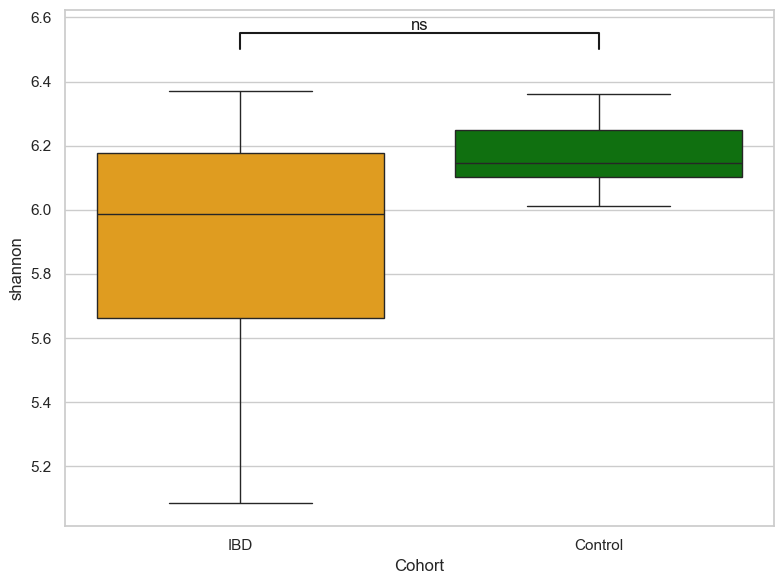

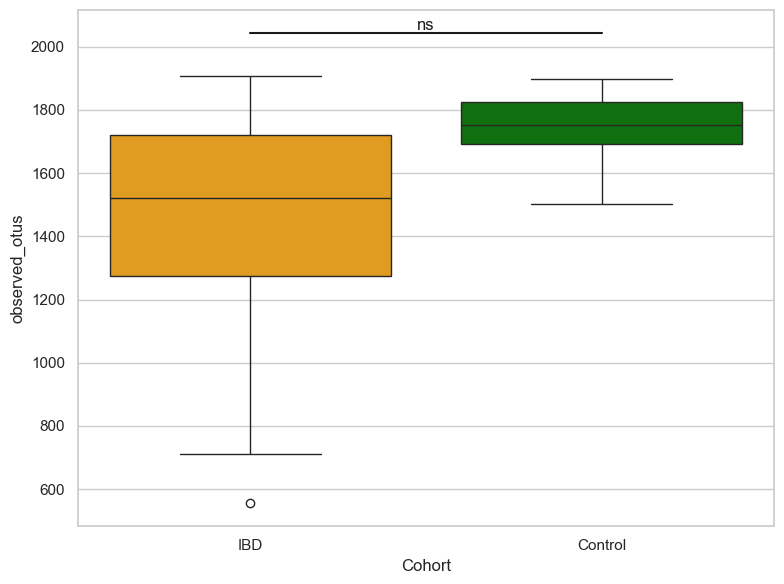

In [28]:
# **Alpha Diversity**
# Calcular métricas de diversidad alfa
metrics = ['shannon', 'observed_otus']
alpha_subfam_neg_ibd = {metric: alpha_diversity(metric, abundance_subfam_neg_ibd.values, abundance_subfam_neg_ibd.index)
                        for metric in metrics}
alpha_subfam_neg_control = {metric: alpha_diversity(metric, abundance_subfam_neg_control.values, abundance_subfam_neg_control.index)
                            for metric in metrics}

# Convertir resultados a DataFrame
alpha_subfam_neg_ibd_df = pd.DataFrame(alpha_subfam_neg_ibd, index=abundance_subfam_neg_ibd.index)
alpha_subfam_neg_control_df = pd.DataFrame(alpha_subfam_neg_control, index=abundance_subfam_neg_control.index)

# Añadir una columna que indique el grupo ('IBD-' o 'control-')
alpha_subfam_neg_ibd_df['tubo'] = 'IBD'
alpha_subfam_neg_control_df['tubo'] = 'Control'

# Mapeo de colores para los grupos
color_map = {'IBD': 'orange', 'Control': 'green'}

# Concatenar los DataFrames de ambos grupos
alpha_subfam_combined_tubo = pd.concat([alpha_subfam_neg_ibd_df, alpha_subfam_neg_control_df])
# Función para agregar la línea y la anotación de significancia
def add_significance_line(ax, group1, group2, y_position, p_value):
    """Agrega una línea y anotación de significancia entre dos grupos."""
    x1, x2 = group1, group2
    y, h, col = y_position, 0.05, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    significance = "ns" if p_value > 0.05 else ("*" if p_value <= 0.05 else ("**" if p_value <= 0.01 else ("***" if p_value <= 0.001 else "****")))
    ax.text((x1 + x2) * 0.5, y + h, significance, ha='center', va='bottom', color=col)
# Iterar a través de las métricas
for metric in metrics:
    # Valores de los dos grupos
    ibd_neg_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'IBD'][metric]
    control_neg_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'Control'][metric]
    
       # Graficar Box Plot
    plt.figure(figsize=(8, 6))
    ax = sns.boxplot(data=alpha_subfam_combined_tubo, x='tubo', y=metric, palette=color_map, hue= 'tubo')
    #plt.title(f"{metric}")
    plt.xlabel("Cohort")
    plt.ylabel(metric)
    
    # Calcular la posición dinámica de la línea de significancia
    max_y = alpha_subfam_combined_tubo[metric].max()  # Valor máximo de la métrica
    margin = 0.1 * (max_y - alpha_subfam_combined_tubo[metric].min())  # Margen basado en el rango
    line_y_position = max_y + margin  # Posición de la línea

    # Agregar línea de significancia y anotación
    add_significance_line(ax, 0, 1, line_y_position, p_value)
    
    plt.tight_layout()
    plt.show()


## Fig 8


ANOVA para la métrica 'shannon':
F-statistic: 18.0712, p-value: 7.1815e-09


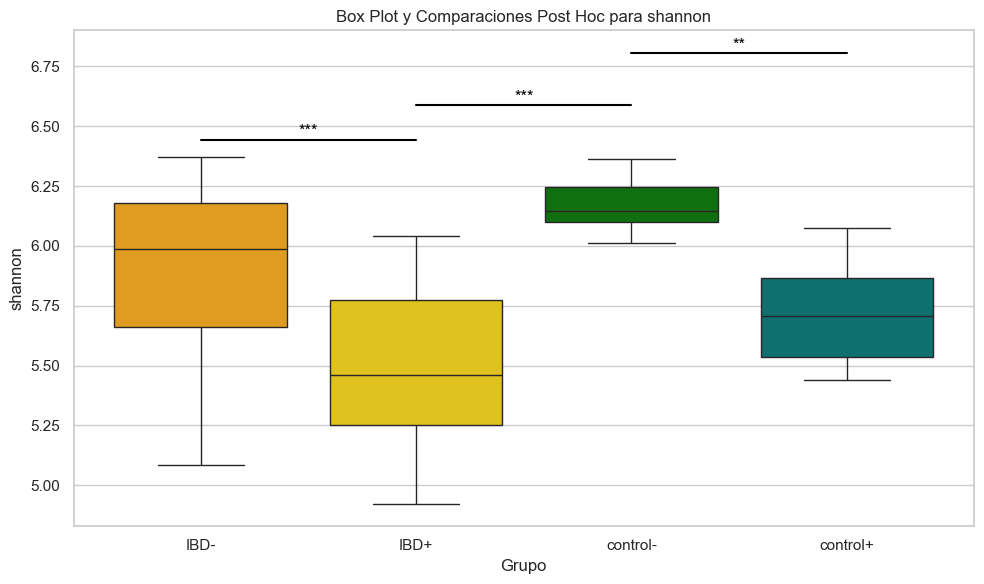


ANOVA para la métrica 'simpson':
F-statistic: 8.3286, p-value: 7.7832e-05


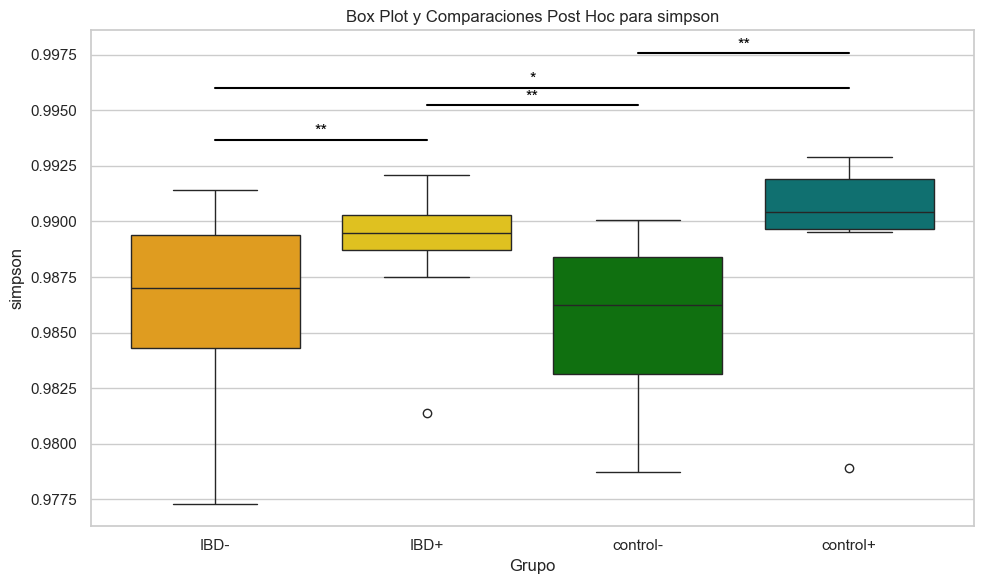


ANOVA para la métrica 'observed_otus':
F-statistic: 11.5271, p-value: 2.8589e-06


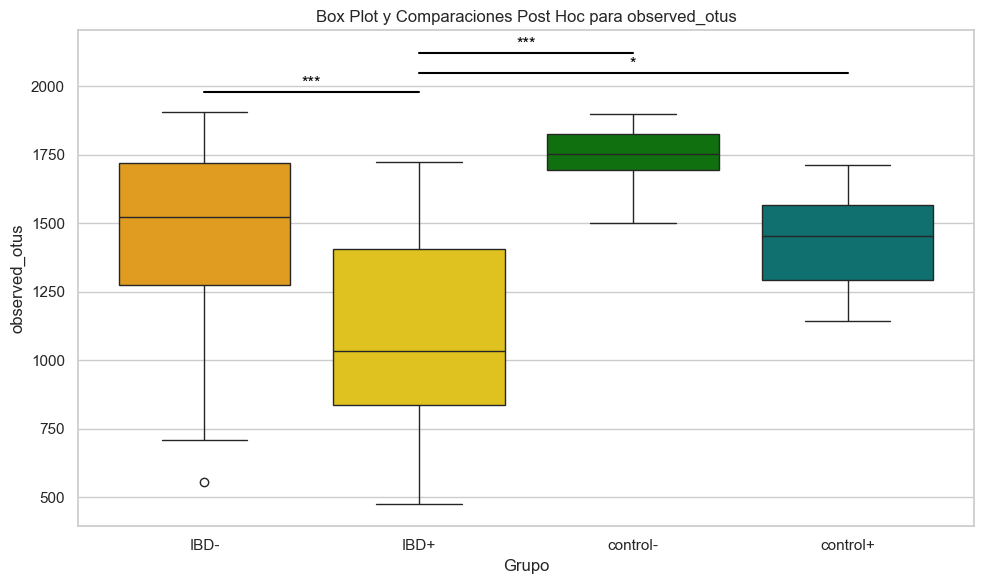

In [29]:
# **Alpha Diversity**
# Calcular métricas de diversidad alfa
metrics = ['shannon', 'simpson', 'observed_otus']
alpha_subfam_neg_ibd = {metric: alpha_diversity(metric, abundance_subfam_neg_ibd.values, abundance_subfam_neg_ibd.index)
                 for metric in metrics}
alpha_subfam_pos_ibd= {metric: alpha_diversity(metric, abundance_subfam_pos_ibd.values, abundance_subfam_pos_ibd.index)
                 for metric in metrics}
alpha_subfam_neg_control = {metric: alpha_diversity(metric, abundance_subfam_neg_control.values, abundance_subfam_neg_control.index)
                 for metric in metrics}
alpha_subfam_pos_control= {metric: alpha_diversity(metric, abundance_subfam_pos_control.values, abundance_subfam_pos_control.index)
                 for metric in metrics}

# Convertir resultados a DataFrame
alpha_subfam_neg_ibd_df = pd.DataFrame(alpha_subfam_neg_ibd, index=abundance_subfam_neg_ibd.index)
alpha_subfam_pos_ibd_df = pd.DataFrame(alpha_subfam_pos_ibd, index=abundance_subfam_pos_ibd.index)
alpha_subfam_neg_control_df = pd.DataFrame(alpha_subfam_neg_control, index=abundance_subfam_neg_control.index)
alpha_subfam_pos_control_df = pd.DataFrame(alpha_subfam_pos_control, index=abundance_subfam_pos_control.index)


# Añadir una columna que indique el grupo ('ref' o 'rew')
alpha_subfam_neg_ibd_df['tubo'] = 'IBD-'
alpha_subfam_pos_ibd_df['tubo'] = 'IBD+'
alpha_subfam_neg_control_df['tubo'] = 'control-'
alpha_subfam_pos_control_df['tubo'] = 'control+'
# Concatenar los DataFrames de ambos grupos
alpha_subfam_combined_tubo = pd.concat([alpha_subfam_neg_ibd_df, alpha_subfam_pos_ibd_df, alpha_subfam_neg_control_df, alpha_subfam_pos_control_df])

    # Mapeo de colores para los grupos
color_map = {
    'IBD-': 'orange',       # Naranja (diferente de rojo)
    'IBD+': 'gold',       # Púrpura intenso
    'control-': 'green',     # Verde azulado
    'control+': 'teal'      # Amarillo dorado
}
# Iterar a través de las métricas
for metric in ['shannon', 'simpson', 'observed_otus']:
    # Realizar ANOVA
    ibd_neg_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'IBD-'][metric]
    ibd_pos_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'IBD+'][metric]
    control_neg_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'control-'][metric]
    control_pos_values = alpha_subfam_combined_tubo[alpha_subfam_combined_tubo['tubo'] == 'control+'][metric]
    
    # ANOVA de un factor
    anova_result = f_oneway(ibd_neg_values, ibd_pos_values, control_neg_values, control_pos_values)
    print(f"\nANOVA para la métrica '{metric}':")
    print(f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}")
    
    # Preparar los datos para Tukey HSD
    tukey_data = alpha_subfam_combined_tubo[[metric, 'tubo']].dropna()
    tukey_test = pairwise_tukeyhsd(endog=tukey_data[metric], groups=tukey_data['tubo'], alpha=0.05)
    
        # Extraer los resultados para visualización
    tukey_results = pd.DataFrame(data=tukey_test.summary().data[1:], columns=tukey_test.summary().data[0])

    # Graficar Box Plot con superposición de p-valores y rayas
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=alpha_subfam_combined_tubo, x='tubo', y=metric, palette=color_map, hue='tubo')
    plt.title(f"Box Plot y Comparaciones Post Hoc para {metric}")
    plt.xlabel("Grupo")
    plt.ylabel(metric)
    # Calcular el máximo valor y ajustes para las líneas
    max_y = tukey_data[metric].max()  # Valor máximo en los datos
    min_y = tukey_data[metric].min()  # Valor mínimo en los datos
    y_increment = (max_y - min_y) * 0.05  # Incremento basado en el rango
    line_offset = y_increment  # Espaciado entre líneas
    
    # Añadir significancia y rayas
    for i, row in tukey_results.iterrows():
        group1 = row['group1']
        group2 = row['group2']
        p_value = row['p-adj']
        
        if p_value < 0.05:  # Solo para comparaciones significativas
            group1_idx = ['IBD-', 'IBD+', 'control-', 'control+'].index(group1)
            group2_idx = ['IBD-', 'IBD+', 'control-', 'control+'].index(group2)
            
            # Determinar posición para la raya
            y_pos = max_y + line_offset * (i + 1)  # Altura incremental para cada comparación
            
            # Dibujar raya
            plt.plot([group1_idx, group2_idx], [y_pos, y_pos], color='black', lw=1.5)
            
            # Determinar número de asteriscos según p-valor
            if p_value < 0.001:
                significance = '***'
            elif p_value < 0.01:
                significance = '**'
            elif p_value < 0.05:
                significance = '*'
            else:
                significance = 'n.s.'  # No significativo
            
            # Añadir texto con asteriscos
            plt.text(
                x=(group1_idx + group2_idx) / 2,
                y=y_pos + (line_offset * 0.2),  # Ajustar un poco más arriba de la raya
                s=significance,
                ha='center',
                fontsize=12,
                color="black"
            )
    
    plt.tight_layout()
    plt.show()


C:\Users\milagros.trotta\AppData\Local\anaconda3\envs\cazymes\Lib\site-packages\skbio\stats\ordination\_principal_coordinate_analysis.py:214: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.11170606936473541 whereas the largest positive one is 7.209588052426848.
  warn(


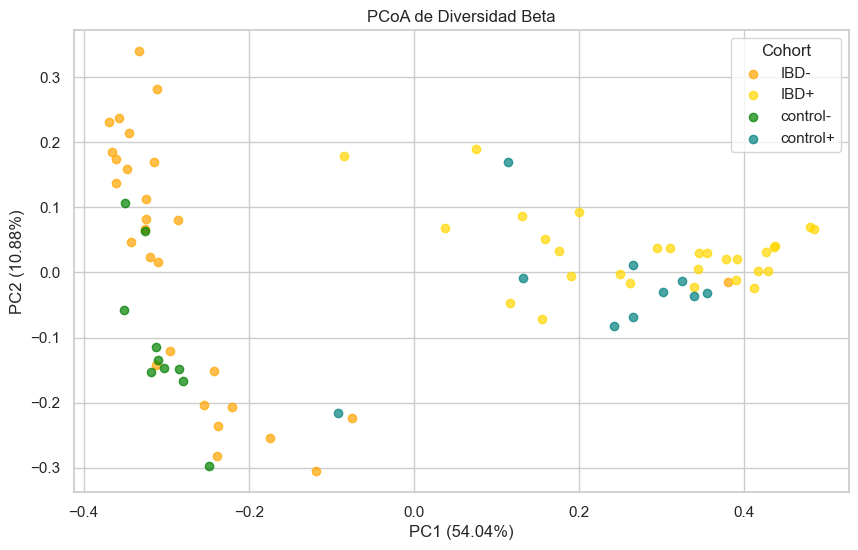

In [30]:
# Combinar ambos grupos en una sola tabla de abundancia
subfam_abundance_table_tubo = pd.concat([abundance_subfam_neg_ibd, abundance_subfam_pos_ibd, abundance_subfam_neg_control, abundance_subfam_pos_control])
subfam_abundance_table_tubo = subfam_abundance_table_tubo.fillna(0)
# **Beta Diversity**
# Calcular diversidad beta usando Bray-Curtis
from skbio.diversity import beta_diversity
metric = 'braycurtis'
beta_matrix_subfam_tubo = beta_diversity(metric, subfam_abundance_table_tubo.values, ids=subfam_abundance_table_tubo.index)

# Convertir a matriz cuadrada para visualizar
beta_square_subfam_tubo = squareform(beta_matrix_subfam_tubo.to_data_frame().values)
# **PCoA**
# Ejecutar PCoA
from skbio.stats.ordination import pcoa
pcoa_subfam_results_tubo = pcoa(beta_matrix_subfam_tubo)

# Extraer coordenadas principales
pcoa_subfam_tubo = pcoa_subfam_results_tubo.samples
pcoa_subfam_tubo['tubo'] = ['IBD-'] * len(abundance_subfam_neg_ibd) + ['IBD+'] * len(abundance_subfam_pos_ibd) +['control-'] * len(abundance_subfam_neg_control) + ['control+'] * len(abundance_subfam_pos_control)  # Asignar grupo
# **Visualización**
plt.figure(figsize=(10, 6))

# Mapeo de colores para los grupos
color_map = {
    'IBD-': 'orange',       # Naranja (diferente de rojo)
    'IBD+': 'gold',       # Púrpura intenso
    'control-': 'green',     # Verde azulado
    'control+': 'teal'      # Amarillo dorado
}

# Graficar cada grupo con etiquetas
for group, color in color_map.items():
    subset = pcoa_subfam_tubo[pcoa_subfam_tubo['tubo'] == group]
    plt.scatter(
        subset['PC1'], subset['PC2'], 
        alpha=0.7, c=color, label=group
    )

# Títulos y etiquetas de los ejes
plt.title("PCoA de Diversidad Beta")
plt.xlabel("PC1 (%.2f%%)" % (pcoa_subfam_results_tubo.proportion_explained['PC1'] * 100))
plt.ylabel("PC2 (%.2f%%)" % (pcoa_subfam_results_tubo.proportion_explained['PC2'] * 100))
plt.grid(True)

# Agregar leyenda
plt.legend(title='Cohort')

# Mostrar gráfico
plt.show()


## Fig 9

In [13]:
df_pos = df_rom[df_rom['tubo'] == 'pos']
control_pos = control[control['tubo'] == 'pos']
df_pos_subfam = df_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
df_neg_subfam = df_neg.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
control_pos_subfam = control_pos.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()
control_neg_subfam = control_neg.groupby(['subfam', 'muestra_id'])['value'].sum().reset_index()


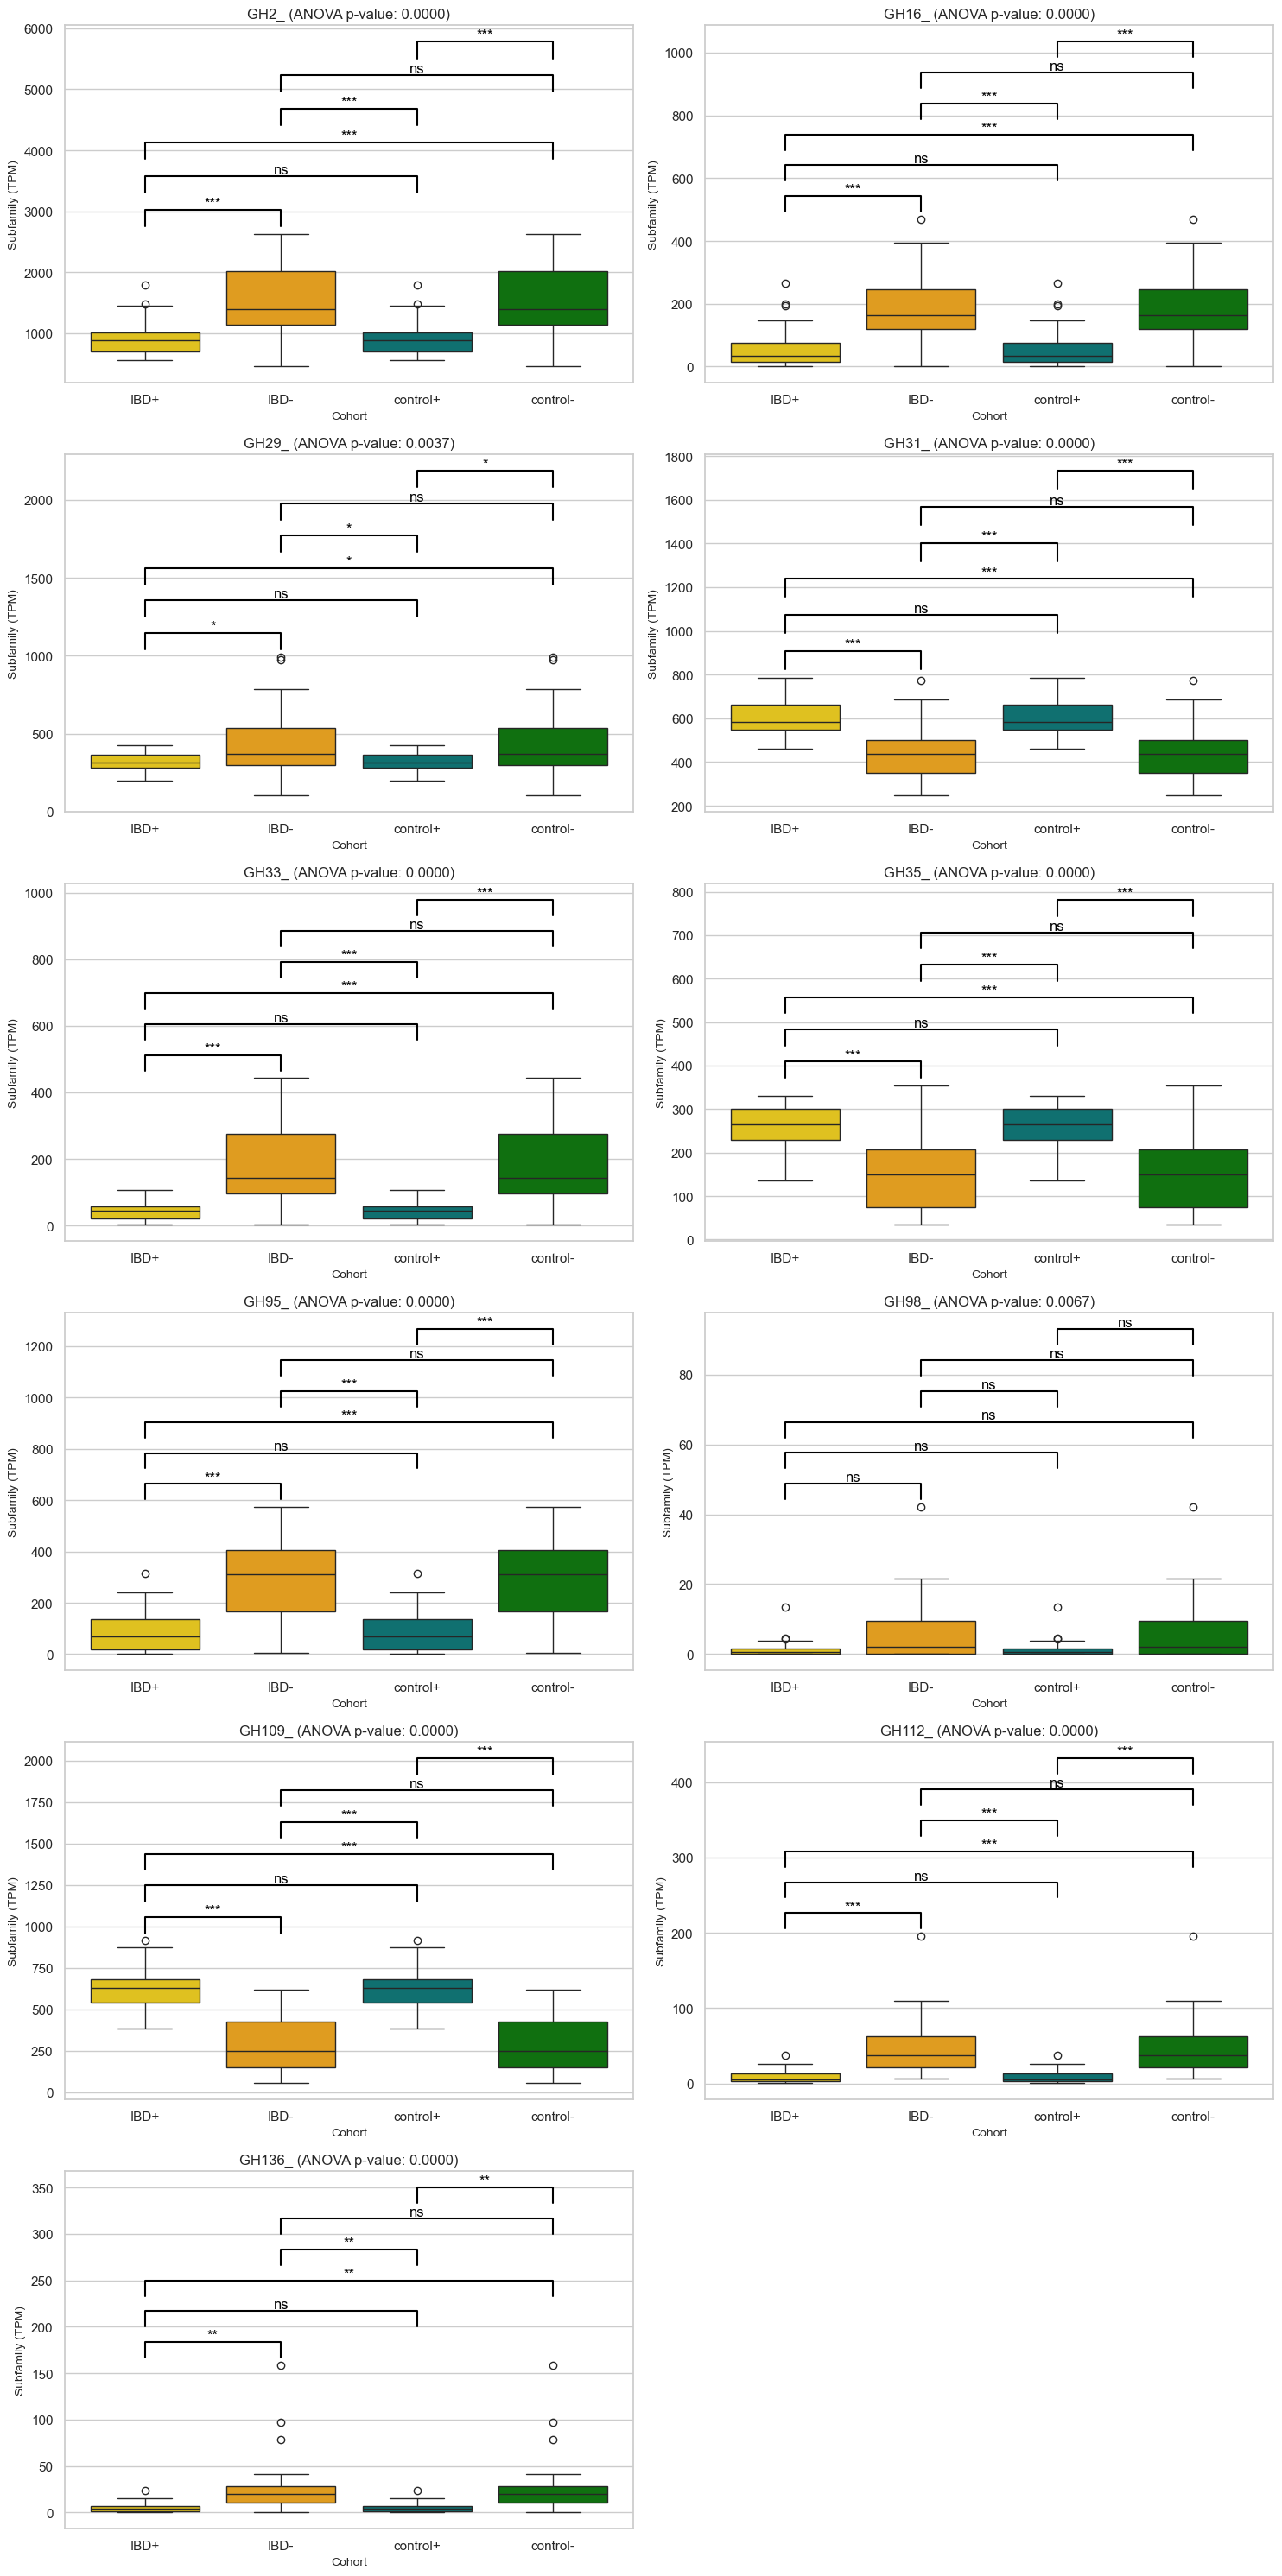

In [16]:
# Crear un patrón para buscar subfamilias
subfam = ['GH2_', 'GH16_', 'GH29_', 'GH31_', 'GH33_', 'GH35_', 'GH95_', 'GH98_', 'GH109_', 'GH112_', 'GH136_']
pattern = '|'.join(f'^{prefix}' for prefix in subfam)

# Filtrar los dataframes usando los prefijos en `subfam`
pos_subfam_filtered = df_pos_subfam[df_pos_subfam['subfam'].str.contains(pattern, regex=True, na=False)]
neg_subfam_filtered = df_neg_subfam[df_neg_subfam['subfam'].str.contains(pattern, regex=True, na=False)]
pos_subfam_filtered = df_pos_subfam[df_pos_subfam['subfam'].str.contains(pattern, regex=True, na=False)]
neg_subfam_filtered = df_neg_subfam[df_neg_subfam['subfam'].str.contains(pattern, regex=True, na=False)]
# Determinar el número de filas y columnas
nrows = len(subfam) // 2 + len(subfam) % 2  # Redondear hacia arriba para un número impar de subfamilias
ncols = 2

# Crear subplots organizados
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))  # Ajustar tamaño según necesidad
axes = axes.flatten()  # Aplanar para iterar fácilmente

# Función para determinar el número de asteriscos según el valor p
def significance_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

# Iterar sobre las subfamilias
for ax, subfam_item in zip(axes, subfam):
    # Crear dataframes agrupados para cada grupo (IBD_Pos, IBD_Neg, etc.)
    dataframes_ibd = {}
    datasets_ibd = {
        'IBD+': pos_subfam_filtered,
        'IBD-': neg_subfam_filtered,
        'control+': pos_subfam_filtered,
        'control-': neg_subfam_filtered
    }
    
    for group_name, dataset_ibd in datasets_ibd.items():
        # Filtrar las subfamilias por el prefijo actual
        df_filtered_ibd = dataset_ibd[dataset_ibd['subfam'].str.contains(f'^{subfam_item}', regex=True, na=False)].copy()
        
        if not df_filtered_ibd.empty:
            # Agrupar por muestra_id y sumar valores
            df_grouped_ibd = df_filtered_ibd.groupby('muestra_id').agg({
                'value': 'sum',
                'subfam': 'first'  # Opcional: Mantener la primera subfamilia como referencia
            }).reset_index()
            
            # Añadir la columna de grupo
            df_grouped_ibd['grupo'] = group_name
            
            # Guardar en el diccionario
            dataframes_ibd[group_name] = df_grouped_ibd
    
    # Combinar todos los dataframes en uno solo
    df_combined_subfam_ibd = pd.concat(dataframes_ibd.values())
    
    color_map = {
        'IBD-': 'orange',       
        'IBD+': 'gold',       
        'control-': 'green',     
        'control+': 'teal'      
    }
    # Crear el boxplot
    sns.boxplot(x='grupo', y='value', hue='grupo', data=df_combined_subfam_ibd, palette=color_map, ax=ax, dodge=False)
    ax.legend([],[], frameon=False)  # Ocultar leyenda individual
    
    # Realizar ANOVA
    groups_ibd = [df_combined_subfam_ibd[df_combined_subfam_ibd['grupo'] == grupo]['value'] for grupo in df_combined_subfam_ibd['grupo'].unique()]
    f_stat, p_value = stats.f_oneway(*groups_ibd)
    
    # Agregar título con p-value de ANOVA
    ax.set_title(f'{subfam_item} (ANOVA p-value: {p_value:.4f})', fontsize=12)
    ax.set_xlabel('Cohort', fontsize=10)
    ax.set_ylabel('Subfamily (TPM)', fontsize=10)
    
    # Si el valor p del ANOVA es significativo, realizar prueba de Tukey
    if p_value < 0.05:
        tukey_result = pairwise_tukeyhsd(df_combined_subfam_ibd['value'], df_combined_subfam_ibd['grupo'], alpha=0.05)
        
        # Altura inicial para las líneas
        max_val = df_combined_subfam_ibd['value'].max() * 1.05
        increment = max_val * 0.1

        # Dibujar líneas y asteriscos para comparaciones significativas
        for comparison in tukey_result.summary().data[1:]:
            group1, group2, meandiff, p_val, reject = comparison[:5]
            
            if reject:  # Solo mostrar comparaciones significativas
                # Posiciones de los grupos
                pos1 = list(df_combined_subfam_ibd['grupo'].unique()).index(group1)
                pos2 = list(df_combined_subfam_ibd['grupo'].unique()).index(group2)
                
                # Dibujar línea
                ax.plot([pos1, pos1, pos2, pos2], [max_val, max_val + increment, max_val + increment, max_val],
                        lw=1.5, color='black')
                
                # Agregar asteriscos
                ax.text((pos1 + pos2) / 2, max_val + increment + 0.05, significance_stars(p_val),
                        ha='center', va='bottom', color='black', fontsize=12)
                
                # Incrementar altura para la próxima comparación
                max_val += increment * 2

# Ocultar ejes sobrantes si hay menos subfamilias que subplots
for ax in axes[len(subfam):]:
    ax.axis('off')

# Ajustar diseño
plt.tight_layout()
plt.show()
